In [1]:
# basics
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

import pickle 

# Keras Libraries
import keras
import tensorflow as tf
from keras import backend as K
from keras import metrics
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.metrics import AUC
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import keras.backend

In [2]:
# Set a seed value
seed_value= 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

# 5. For layers that introduce randomness like dropout, make sure to set seed values 
#model.add(Dropout(0.25, seed=seed_value))


In [3]:
project_path = "/Users/freazx/Documents/ONE TAB/CODING"
train_path = project_path + "/chest_xray/setB/train/"
val_path = project_path + "/chest_xray/setB/val/"
test_path = project_path + "/chest_xray/setB/test/"

In [4]:
hyper_dimension = 64
hyper_batch_size = 128
hyper_epochs = 100

## Training in grayscale instead of RGB
hyper_channels = 1
hyper_mode = 'grayscale'

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale=1.0/255.0) 
test_datagen = ImageDataGenerator(rescale=1.0/255.0) 

train_generator = train_datagen.flow_from_directory(directory = train_path, 
                                                    target_size = (hyper_dimension, hyper_dimension),
                                                    batch_size = hyper_batch_size, 
                                                    color_mode = hyper_mode,
                                                    class_mode = 'binary', 
                                                    seed = 42)
val_generator = val_datagen.flow_from_directory(directory = val_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'binary',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)
test_generator = test_datagen.flow_from_directory(directory = test_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'binary',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)

test_generator.reset()

Found 4104 images belonging to 2 classes.
Found 871 images belonging to 2 classes.
Found 876 images belonging to 2 classes.


In [6]:
def create_charts(cnn, cnn_model):
    ## Define train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[3]
    val_auc_name = list(cnn_model.history.keys())[1]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict(test_generator, steps=len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
    # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Normal', 'Pneumonia']

    # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
     ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    ;
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

In [7]:
#Model 1 : Conv2D x 3 + 64 dense units
cnn = Sequential()
cnn.add(InputLayer(shape=(hyper_dimension, hyper_dimension, hyper_channels)))
                                
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=64))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit(train_generator,
                   epochs=100,
                   validation_data=val_generator,
                   steps_per_epoch=len(train_generator),
                   validation_steps=len(val_generator),
                   verbose=1)

Epoch 1/100


/Users/freazx/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 713ms/step - auc: 0.5073 - loss: 0.6137 - val_auc: 0.8492 - val_loss: 0.5415
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100


2024-03-30 18:32:57.207103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/freazx/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-30 18:32:57.211715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 638ms/step - auc: 0.7925 - loss: 0.5063 - val_auc: 0.9353 - val_loss: 0.4022
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/100


2024-03-30 18:33:22.007396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:33:22.009851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 625ms/step - auc: 0.8784 - loss: 0.3887 - val_auc: 0.9514 - val_loss: 0.4054
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/100


2024-03-30 18:33:46.980484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:33:46.983444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 624ms/step - auc: 0.9430 - loss: 0.2737 - val_auc: 0.9574 - val_loss: 0.2905
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/100


2024-03-30 18:34:12.007218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:34:12.010882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 629ms/step - auc: 0.9546 - loss: 0.2410 - val_auc: 0.9622 - val_loss: 0.2248
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/100


2024-03-30 18:34:36.909647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:34:36.912231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 617ms/step - auc: 0.9491 - loss: 0.2528 - val_auc: 0.9445 - val_loss: 0.5636
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/100


2024-03-30 18:35:01.427735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:35:01.430709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 618ms/step - auc: 0.9453 - loss: 0.2716 - val_auc: 0.9636 - val_loss: 0.3072
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 15/100


2024-03-30 18:35:26.241331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:35:26.244825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 631ms/step - auc: 0.9493 - loss: 0.2523 - val_auc: 0.9678 - val_loss: 0.2570
Epoch 16/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 17/100


2024-03-30 18:35:50.938058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:35:50.941044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 646ms/step - auc: 0.9634 - loss: 0.2069 - val_auc: 0.9730 - val_loss: 0.2343
Epoch 18/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/100


2024-03-30 18:36:15.919812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:36:15.922612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 625ms/step - auc: 0.9674 - loss: 0.2036 - val_auc: 0.9743 - val_loss: 0.1840
Epoch 20/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 21/100


2024-03-30 18:36:40.869833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:36:40.872371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 671ms/step - auc: 0.9688 - loss: 0.2021 - val_auc: 0.9781 - val_loss: 0.1826
Epoch 22/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 23/100


2024-03-30 18:37:07.278102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:37:07.281548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 674ms/step - auc: 0.9676 - loss: 0.2050 - val_auc: 0.9761 - val_loss: 0.2050
Epoch 24/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 25/100


2024-03-30 18:37:34.002957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:37:34.006061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 681ms/step - auc: 0.9708 - loss: 0.2056 - val_auc: 0.9777 - val_loss: 0.2110
Epoch 26/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 27/100


2024-03-30 18:38:00.674705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:38:00.678628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 675ms/step - auc: 0.9696 - loss: 0.2004 - val_auc: 0.9790 - val_loss: 0.1797
Epoch 28/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 29/100


2024-03-30 18:38:26.686855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:38:26.689506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 645ms/step - auc: 0.9776 - loss: 0.1682 - val_auc: 0.9810 - val_loss: 0.1809
Epoch 30/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 31/100


2024-03-30 18:38:52.379472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:38:52.382394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 659ms/step - auc: 0.9790 - loss: 0.1597 - val_auc: 0.9828 - val_loss: 0.1498
Epoch 32/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 33/100


2024-03-30 18:39:17.883450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:39:17.886368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 638ms/step - auc: 0.9845 - loss: 0.1451 - val_auc: 0.9833 - val_loss: 0.1725
Epoch 34/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 35/100


2024-03-30 18:39:43.667660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:39:43.670376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 639ms/step - auc: 0.9827 - loss: 0.1521 - val_auc: 0.9811 - val_loss: 0.2049
Epoch 36/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 37/100


2024-03-30 18:40:09.108382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:40:09.111277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 654ms/step - auc: 0.9824 - loss: 0.1474 - val_auc: 0.9838 - val_loss: 0.1516
Epoch 38/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 39/100


2024-03-30 18:40:34.674024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:40:34.676926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 648ms/step - auc: 0.9829 - loss: 0.1446 - val_auc: 0.9801 - val_loss: 0.1575
Epoch 40/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 41/100


2024-03-30 18:41:00.486202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:41:00.488836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 652ms/step - auc: 0.9838 - loss: 0.1424 - val_auc: 0.9843 - val_loss: 0.1309
Epoch 42/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 43/100


2024-03-30 18:41:26.396079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:41:26.398775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 641ms/step - auc: 0.9878 - loss: 0.1242 - val_auc: 0.9861 - val_loss: 0.1805
Epoch 44/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 216us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 45/100


2024-03-30 18:41:52.077512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:41:52.080106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 630ms/step - auc: 0.9862 - loss: 0.1313 - val_auc: 0.9851 - val_loss: 0.1271
Epoch 46/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 47/100


2024-03-30 18:42:17.291076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:42:17.293995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 655ms/step - auc: 0.9855 - loss: 0.1344 - val_auc: 0.9796 - val_loss: 0.1637
Epoch 48/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 49/100


2024-03-30 18:42:42.552666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:42:42.555591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 643ms/step - auc: 0.9782 - loss: 0.1689 - val_auc: 0.9833 - val_loss: 0.1655
Epoch 50/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 51/100


2024-03-30 18:43:07.925343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:43:07.928887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 648ms/step - auc: 0.9855 - loss: 0.1374 - val_auc: 0.9835 - val_loss: 0.1473
Epoch 52/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 53/100


2024-03-30 18:43:33.310344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:43:33.314777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 645ms/step - auc: 0.9843 - loss: 0.1388 - val_auc: 0.9841 - val_loss: 0.1359
Epoch 54/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 55/100


2024-03-30 18:43:58.735825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:43:58.738342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 660ms/step - auc: 0.9870 - loss: 0.1283 - val_auc: 0.9834 - val_loss: 0.1508
Epoch 56/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 57/100


2024-03-30 18:44:24.695154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:44:24.697838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 628ms/step - auc: 0.9830 - loss: 0.1484 - val_auc: 0.9814 - val_loss: 0.1441
Epoch 58/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 59/100


2024-03-30 18:44:49.987529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:44:49.990213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 632ms/step - auc: 0.9840 - loss: 0.1392 - val_auc: 0.9753 - val_loss: 0.1680
Epoch 60/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 61/100


2024-03-30 18:45:15.198788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:45:15.202027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 624ms/step - auc: 0.9861 - loss: 0.1361 - val_auc: 0.9836 - val_loss: 0.1342
Epoch 62/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 63/100


2024-03-30 18:45:40.162699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:45:40.165535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 688ms/step - auc: 0.9842 - loss: 0.1389 - val_auc: 0.9793 - val_loss: 0.1597
Epoch 64/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 65/100


2024-03-30 18:46:07.213065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:46:07.216175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 682ms/step - auc: 0.9870 - loss: 0.1291 - val_auc: 0.9849 - val_loss: 0.1409
Epoch 66/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 67/100


2024-03-30 18:46:33.699158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:46:33.702245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 685ms/step - auc: 0.9844 - loss: 0.1332 - val_auc: 0.9822 - val_loss: 0.1398
Epoch 68/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 69/100


2024-03-30 18:47:00.822088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:47:00.826319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 600ms/step - auc: 0.9837 - loss: 0.1633 - val_auc: 0.9837 - val_loss: 0.1320
Epoch 70/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 71/100


2024-03-30 18:47:25.085897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:47:25.088944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 650ms/step - auc: 0.9899 - loss: 0.1165 - val_auc: 0.9817 - val_loss: 0.1401
Epoch 72/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 73/100


2024-03-30 18:47:51.511891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:47:51.514584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 617ms/step - auc: 0.9870 - loss: 0.1310 - val_auc: 0.9851 - val_loss: 0.1322
Epoch 74/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 75/100


2024-03-30 18:48:16.311781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:48:16.314337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 636ms/step - auc: 0.9882 - loss: 0.1273 - val_auc: 0.9752 - val_loss: 0.1632
Epoch 76/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 77/100


2024-03-30 18:48:40.958001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:48:40.960501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 644ms/step - auc: 0.9842 - loss: 0.1331 - val_auc: 0.9847 - val_loss: 0.1508
Epoch 78/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 79/100


2024-03-30 18:49:05.816107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:49:05.818553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 622ms/step - auc: 0.9856 - loss: 0.1392 - val_auc: 0.9813 - val_loss: 0.1426
Epoch 80/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 81/100


2024-03-30 18:49:30.486906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:49:30.489357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 615ms/step - auc: 0.9862 - loss: 0.1283 - val_auc: 0.9822 - val_loss: 0.1345
Epoch 82/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 83/100


2024-03-30 18:49:55.158429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:49:55.162531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 625ms/step - auc: 0.9905 - loss: 0.1052 - val_auc: 0.9842 - val_loss: 0.1436
Epoch 84/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 85/100


2024-03-30 18:50:19.877292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:50:19.881210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 610ms/step - auc: 0.9903 - loss: 0.1099 - val_auc: 0.9801 - val_loss: 0.1445
Epoch 86/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 87/100


2024-03-30 18:50:44.418208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:50:44.420865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 624ms/step - auc: 0.9884 - loss: 0.1214 - val_auc: 0.9875 - val_loss: 0.1449
Epoch 88/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 89/100


2024-03-30 18:51:09.209522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:51:09.212353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 614ms/step - auc: 0.9887 - loss: 0.1185 - val_auc: 0.9851 - val_loss: 0.1484
Epoch 90/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 91/100


2024-03-30 18:51:33.729423: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:51:33.731926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 615ms/step - auc: 0.9899 - loss: 0.1136 - val_auc: 0.9794 - val_loss: 0.1490
Epoch 92/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 207us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 93/100


2024-03-30 18:51:58.291753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:51:58.294241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 620ms/step - auc: 0.9849 - loss: 0.1257 - val_auc: 0.9850 - val_loss: 0.1423
Epoch 94/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 95/100


2024-03-30 18:52:22.306218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:52:22.308679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 596ms/step - auc: 0.9910 - loss: 0.1049 - val_auc: 0.9790 - val_loss: 0.1552
Epoch 96/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 97/100


2024-03-30 18:52:46.474579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:52:46.477417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 629ms/step - auc: 0.9896 - loss: 0.1101 - val_auc: 0.9867 - val_loss: 0.1267
Epoch 98/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 226us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 99/100


2024-03-30 18:53:11.650478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:53:11.653092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 636ms/step - auc: 0.9879 - loss: 0.1216 - val_auc: 0.9830 - val_loss: 0.1490
Epoch 100/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - auc: 0.0000e+00 - loss: 0.0000e+00 - val_auc: 0.0000e+00 - val_loss: 0.0000e+00


2024-03-30 18:53:37.093619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 18:53:37.097573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 350ms/step
[Summary Statistics]
Accuracy = 92.12% | Precision = 94.13% | Recall = 95.16% | Specificity = 83.90% | F1 Score = 94.64%


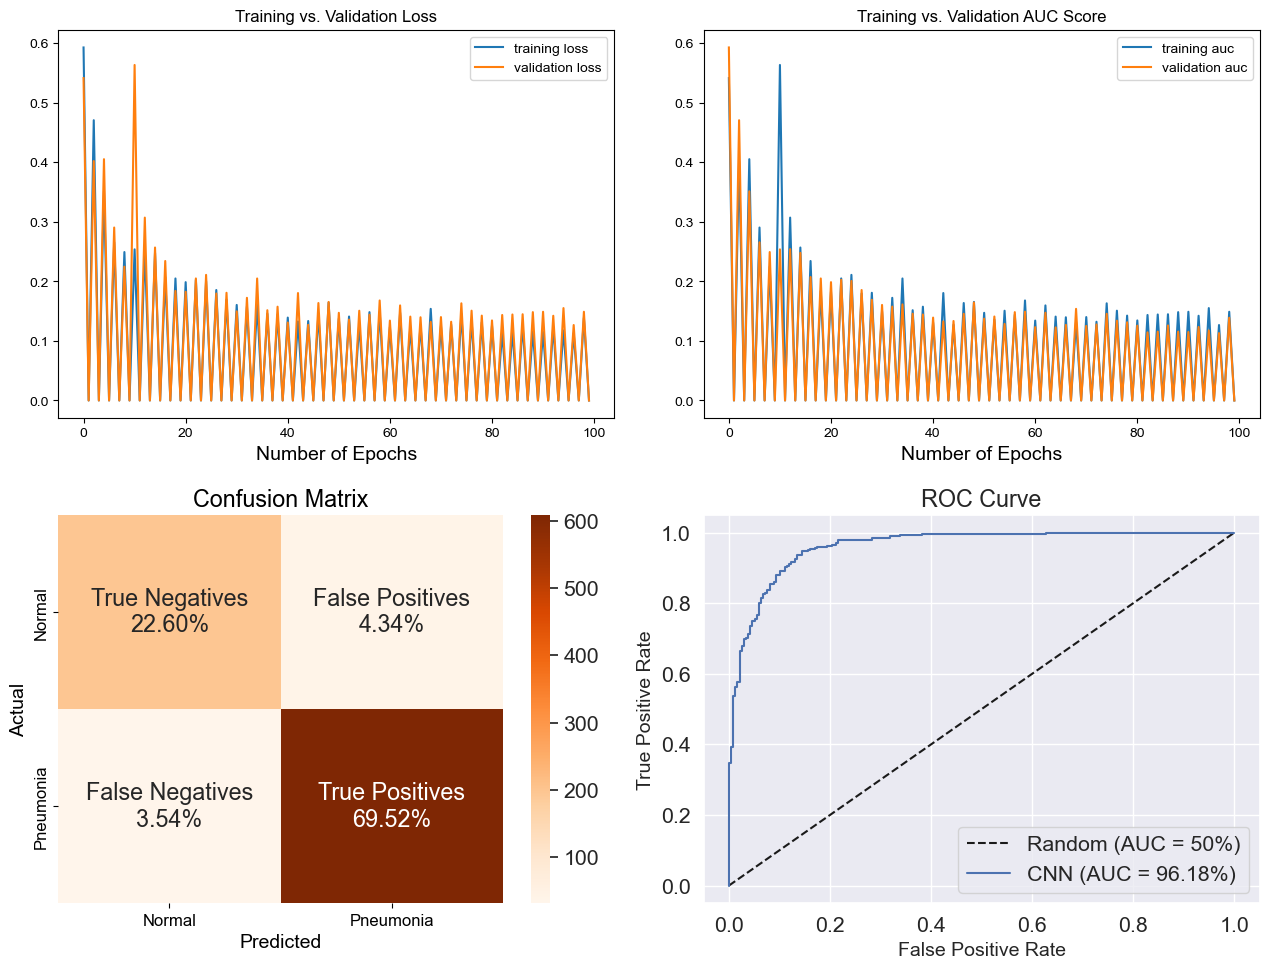

In [8]:
create_charts(cnn, cnn_model)

In [9]:
#Model 2:- Conv2D x 4 + 64 dense units.
cnn = Sequential()
cnn.add(InputLayer(input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=64))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 100, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator))

/Users/freazx/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 712ms/step - auc_1: 0.4890 - loss: 0.6184 - val_auc_1: 0.7154 - val_loss: 0.5717
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100


2024-03-30 19:00:55.283780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/freazx/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-30 19:00:55.287556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 616ms/step - auc_1: 0.6441 - loss: 0.5650 - val_auc_1: 0.9139 - val_loss: 0.4855
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/100


2024-03-30 19:01:19.893231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:01:19.896758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 612ms/step - auc_1: 0.8349 - loss: 0.4730 - val_auc_1: 0.9343 - val_loss: 0.4463
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/100


2024-03-30 19:01:44.567316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:01:44.570160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 627ms/step - auc_1: 0.9052 - loss: 0.3550 - val_auc_1: 0.9553 - val_loss: 0.2576
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 248us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/100


2024-03-30 19:02:09.420488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:02:09.423340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 616ms/step - auc_1: 0.8958 - loss: 0.3470 - val_auc_1: 0.9591 - val_loss: 0.2544
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/100


2024-03-30 19:02:34.118812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:02:34.123943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 645ms/step - auc_1: 0.9478 - loss: 0.2849 - val_auc_1: 0.9541 - val_loss: 0.2945
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/100


2024-03-30 19:02:59.240464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:02:59.243516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 615ms/step - auc_1: 0.9636 - loss: 0.2181 - val_auc_1: 0.9596 - val_loss: 0.3438
Epoch 14/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 15/100


2024-03-30 19:03:24.001707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:03:24.004759: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 619ms/step - auc_1: 0.9625 - loss: 0.2206 - val_auc_1: 0.9662 - val_loss: 0.2769
Epoch 16/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 17/100


2024-03-30 19:03:48.872984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:03:48.875535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 640ms/step - auc_1: 0.9657 - loss: 0.2124 - val_auc_1: 0.9713 - val_loss: 0.3742
Epoch 18/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/100


2024-03-30 19:04:14.640239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:04:14.643465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 637ms/step - auc_1: 0.9638 - loss: 0.2531 - val_auc_1: 0.9683 - val_loss: 0.2457
Epoch 20/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 21/100


2024-03-30 19:04:39.191253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:04:39.193910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 629ms/step - auc_1: 0.9735 - loss: 0.1837 - val_auc_1: 0.9729 - val_loss: 0.3821
Epoch 22/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 23/100


2024-03-30 19:05:04.353269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:05:04.357058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 645ms/step - auc_1: 0.9731 - loss: 0.1837 - val_auc_1: 0.9757 - val_loss: 0.3179
Epoch 24/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 247us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 25/100


2024-03-30 19:05:29.824253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:05:29.827232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 667ms/step - auc_1: 0.9727 - loss: 0.1828 - val_auc_1: 0.9783 - val_loss: 0.2581
Epoch 26/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 27/100


2024-03-30 19:05:55.692319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:05:55.695454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 629ms/step - auc_1: 0.9784 - loss: 0.1634 - val_auc_1: 0.9777 - val_loss: 0.1882
Epoch 28/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 29/100


2024-03-30 19:06:20.822603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:06:20.825649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 636ms/step - auc_1: 0.9761 - loss: 0.1782 - val_auc_1: 0.9775 - val_loss: 0.2360
Epoch 30/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 31/100


2024-03-30 19:06:45.497821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:06:45.500657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 634ms/step - auc_1: 0.9733 - loss: 0.1792 - val_auc_1: 0.9792 - val_loss: 0.1832
Epoch 32/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 33/100


2024-03-30 19:07:10.222396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:07:10.225006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 640ms/step - auc_1: 0.9769 - loss: 0.1663 - val_auc_1: 0.9803 - val_loss: 0.1536
Epoch 34/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 35/100


2024-03-30 19:07:35.038380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:07:35.041082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 648ms/step - auc_1: 0.9783 - loss: 0.1622 - val_auc_1: 0.9820 - val_loss: 0.1639
Epoch 36/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 37/100


2024-03-30 19:08:00.140554: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:08:00.144078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 630ms/step - auc_1: 0.9850 - loss: 0.1434 - val_auc_1: 0.9820 - val_loss: 0.2135
Epoch 38/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 39/100


2024-03-30 19:08:25.362516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:08:25.365558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 616ms/step - auc_1: 0.9801 - loss: 0.1592 - val_auc_1: 0.9819 - val_loss: 0.1498
Epoch 40/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 41/100


2024-03-30 19:08:49.984404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:08:49.987025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 621ms/step - auc_1: 0.9829 - loss: 0.1480 - val_auc_1: 0.9824 - val_loss: 0.2363
Epoch 42/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 43/100


2024-03-30 19:09:14.756343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:09:14.759861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 638ms/step - auc_1: 0.9818 - loss: 0.1531 - val_auc_1: 0.9821 - val_loss: 0.1479
Epoch 44/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 45/100


2024-03-30 19:09:40.218520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:09:40.221033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 604ms/step - auc_1: 0.9787 - loss: 0.1693 - val_auc_1: 0.9833 - val_loss: 0.1424
Epoch 46/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 47/100


2024-03-30 19:10:04.590466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:10:04.593141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 626ms/step - auc_1: 0.9842 - loss: 0.1409 - val_auc_1: 0.9837 - val_loss: 0.1439
Epoch 48/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 49/100


2024-03-30 19:10:29.387890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:10:29.390670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 616ms/step - auc_1: 0.9821 - loss: 0.1452 - val_auc_1: 0.9841 - val_loss: 0.1546
Epoch 50/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 51/100


2024-03-30 19:10:54.039383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:10:54.042003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 612ms/step - auc_1: 0.9824 - loss: 0.1461 - val_auc_1: 0.9805 - val_loss: 0.2386
Epoch 52/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 53/100


2024-03-30 19:11:18.434169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:11:18.436806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 632ms/step - auc_1: 0.9858 - loss: 0.1366 - val_auc_1: 0.9850 - val_loss: 0.1445
Epoch 54/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 55/100


2024-03-30 19:11:43.123443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:11:43.126188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 620ms/step - auc_1: 0.9831 - loss: 0.1424 - val_auc_1: 0.9852 - val_loss: 0.1409
Epoch 56/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 57/100


2024-03-30 19:12:07.966950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:12:07.969531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 626ms/step - auc_1: 0.9867 - loss: 0.1210 - val_auc_1: 0.9852 - val_loss: 0.1361
Epoch 58/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 59/100


2024-03-30 19:12:32.597648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:12:32.600374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 625ms/step - auc_1: 0.9881 - loss: 0.1257 - val_auc_1: 0.9856 - val_loss: 0.1301
Epoch 60/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 61/100


2024-03-30 19:12:57.428673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:12:57.431537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 612ms/step - auc_1: 0.9844 - loss: 0.1465 - val_auc_1: 0.9854 - val_loss: 0.1331
Epoch 62/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 63/100


2024-03-30 19:13:22.142614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:13:22.145552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 609ms/step - auc_1: 0.9859 - loss: 0.1348 - val_auc_1: 0.9853 - val_loss: 0.2300
Epoch 64/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 65/100


2024-03-30 19:13:46.231846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:13:46.234374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 614ms/step - auc_1: 0.9800 - loss: 0.1671 - val_auc_1: 0.9868 - val_loss: 0.1819
Epoch 66/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 67/100


2024-03-30 19:14:10.575775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:14:10.578591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 624ms/step - auc_1: 0.9819 - loss: 0.1495 - val_auc_1: 0.9847 - val_loss: 0.1416
Epoch 68/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 236us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 69/100


2024-03-30 19:14:35.595659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:14:35.598344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 609ms/step - auc_1: 0.9835 - loss: 0.1409 - val_auc_1: 0.9861 - val_loss: 0.1623
Epoch 70/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 71/100


2024-03-30 19:14:59.743823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:14:59.746464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 621ms/step - auc_1: 0.9857 - loss: 0.1390 - val_auc_1: 0.9863 - val_loss: 0.1265
Epoch 72/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 73/100


2024-03-30 19:15:24.122680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:15:24.125300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 625ms/step - auc_1: 0.9862 - loss: 0.1364 - val_auc_1: 0.9859 - val_loss: 0.1339
Epoch 74/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 75/100


2024-03-30 19:15:48.325920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:15:48.328653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 607ms/step - auc_1: 0.9881 - loss: 0.1246 - val_auc_1: 0.9842 - val_loss: 0.2029
Epoch 76/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 77/100


2024-03-30 19:16:12.564784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:16:12.567716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 602ms/step - auc_1: 0.9847 - loss: 0.1469 - val_auc_1: 0.9854 - val_loss: 0.1587
Epoch 78/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 79/100


2024-03-30 19:16:36.780683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:16:36.783227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 609ms/step - auc_1: 0.9896 - loss: 0.1156 - val_auc_1: 0.9854 - val_loss: 0.1451
Epoch 80/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 231us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 81/100


2024-03-30 19:17:00.808084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:17:00.810811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 623ms/step - auc_1: 0.9887 - loss: 0.1159 - val_auc_1: 0.9873 - val_loss: 0.1567
Epoch 82/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 83/100


2024-03-30 19:17:24.871517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:17:24.874203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 606ms/step - auc_1: 0.9906 - loss: 0.1054 - val_auc_1: 0.9871 - val_loss: 0.1391
Epoch 84/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 85/100


2024-03-30 19:17:49.072322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:17:49.074961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 623ms/step - auc_1: 0.9865 - loss: 0.1123 - val_auc_1: 0.9861 - val_loss: 0.1442
Epoch 86/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 87/100


2024-03-30 19:18:13.218765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:18:13.221403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 602ms/step - auc_1: 0.9847 - loss: 0.1277 - val_auc_1: 0.9858 - val_loss: 0.1510
Epoch 88/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 89/100


2024-03-30 19:18:37.242446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:18:37.245078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 598ms/step - auc_1: 0.9904 - loss: 0.1110 - val_auc_1: 0.9835 - val_loss: 0.1328
Epoch 90/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 91/100


2024-03-30 19:19:01.262079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:19:01.264649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 617ms/step - auc_1: 0.9854 - loss: 0.1303 - val_auc_1: 0.9831 - val_loss: 0.1536
Epoch 92/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 93/100


2024-03-30 19:19:25.432417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:19:25.435099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 601ms/step - auc_1: 0.9816 - loss: 0.1371 - val_auc_1: 0.9859 - val_loss: 0.1305
Epoch 94/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 224us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 95/100


2024-03-30 19:19:49.443010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:19:49.445585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 611ms/step - auc_1: 0.9903 - loss: 0.1109 - val_auc_1: 0.9807 - val_loss: 0.1437
Epoch 96/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 97/100


2024-03-30 19:20:13.649723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:20:13.652572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 617ms/step - auc_1: 0.9898 - loss: 0.1147 - val_auc_1: 0.9857 - val_loss: 0.1851
Epoch 98/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 99/100


2024-03-30 19:20:37.702595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:20:37.705241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 598ms/step - auc_1: 0.9875 - loss: 0.1264 - val_auc_1: 0.9860 - val_loss: 0.1439
Epoch 100/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step - auc_1: 0.0000e+00 - loss: 0.0000e+00 - val_auc_1: 0.0000e+00 - val_loss: 0.0000e+00


2024-03-30 19:21:01.786750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:21:01.789643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 350ms/step
[Summary Statistics]
Accuracy = 92.01% | Precision = 93.05% | Recall = 96.25% | Specificity = 80.51% | F1 Score = 94.62%


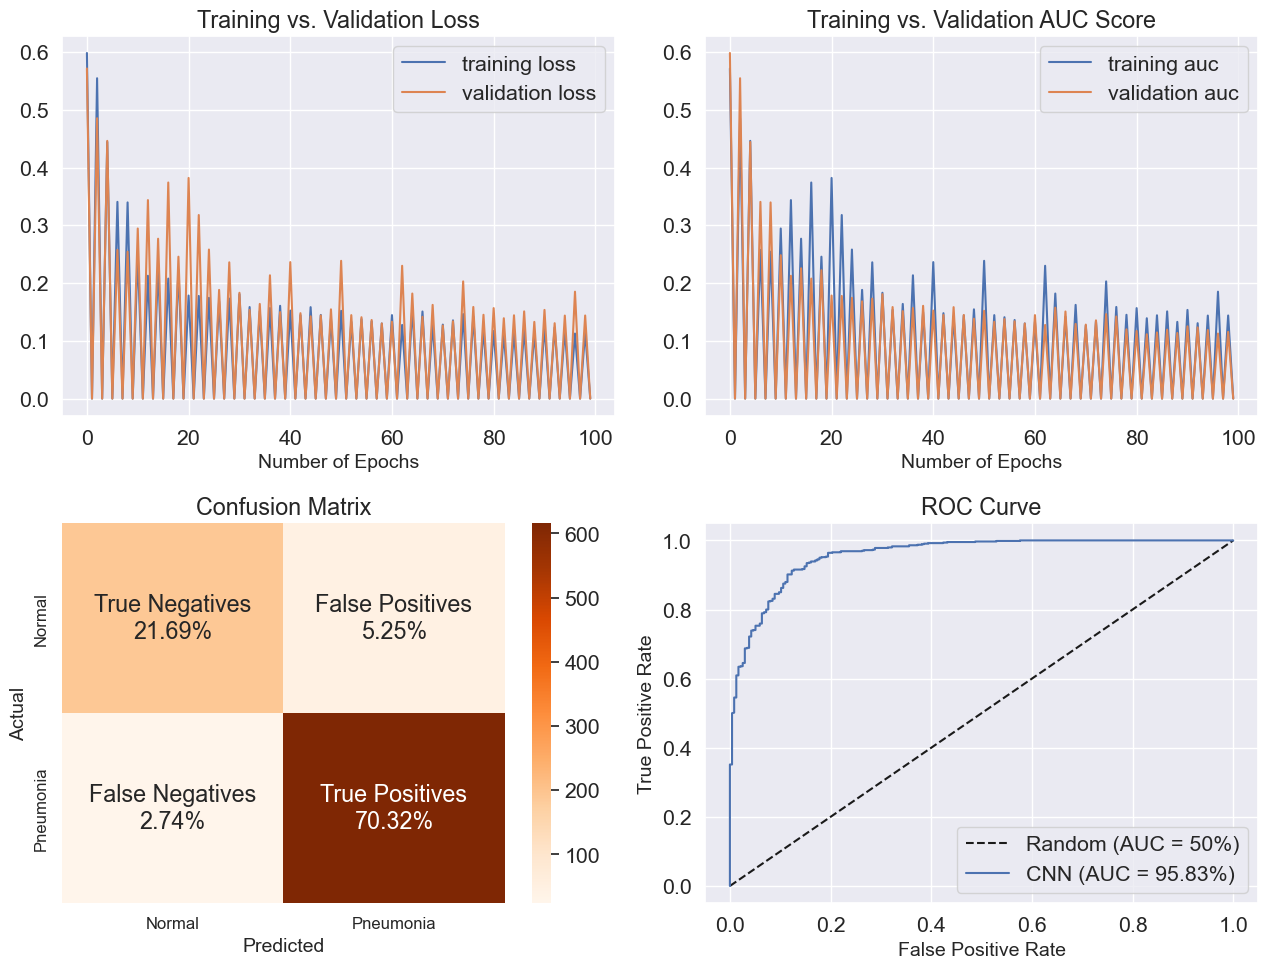

In [10]:
create_charts(cnn, cnn_model)

In [11]:
#Model 3: Conv2D x 2 + 64 dense units.
cnn = Sequential()
cnn.add(InputLayer(shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=64))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 100, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=2)

Epoch 1/100
33/33 - 27s - 805ms/step - auc_2: 0.6989 - loss: 0.5411 - val_auc_2: 0.9617 - val_loss: 0.3801
Epoch 2/100
33/33 - 0s - 380us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100


2024-03-30 19:22:41.515364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/freazx/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-30 19:22:41.518686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_2: 0.8741 - loss: 0.3779 - val_auc_2: 0.9685 - val_loss: 0.2454
Epoch 4/100
33/33 - 0s - 239us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/100


2024-03-30 19:23:05.469741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:23:05.472591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 724ms/step - auc_2: 0.9510 - loss: 0.2570 - val_auc_2: 0.9748 - val_loss: 0.1862
Epoch 6/100
33/33 - 0s - 225us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/100


2024-03-30 19:23:29.381754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:23:29.384571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 742ms/step - auc_2: 0.9608 - loss: 0.2292 - val_auc_2: 0.9771 - val_loss: 0.1747
Epoch 8/100
33/33 - 0s - 234us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/100


2024-03-30 19:23:53.872595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:23:53.875449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 756ms/step - auc_2: 0.9643 - loss: 0.2163 - val_auc_2: 0.9775 - val_loss: 0.1670
Epoch 10/100
33/33 - 0s - 243us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/100


2024-03-30 19:24:18.819890: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:24:18.822997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 740ms/step - auc_2: 0.9724 - loss: 0.1851 - val_auc_2: 0.9800 - val_loss: 0.2157
Epoch 12/100
33/33 - 0s - 234us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/100


2024-03-30 19:24:43.252139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:24:43.255042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 722ms/step - auc_2: 0.9731 - loss: 0.1891 - val_auc_2: 0.9819 - val_loss: 0.2369
Epoch 14/100
33/33 - 0s - 222us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 15/100


2024-03-30 19:25:07.074684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:25:07.077293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 724ms/step - auc_2: 0.9710 - loss: 0.1909 - val_auc_2: 0.9819 - val_loss: 0.1789
Epoch 16/100
33/33 - 0s - 246us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 17/100


2024-03-30 19:25:30.977395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:25:30.980635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_2: 0.9800 - loss: 0.1622 - val_auc_2: 0.9843 - val_loss: 0.1859
Epoch 18/100
33/33 - 0s - 244us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/100


2024-03-30 19:25:54.898018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:25:54.900968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 735ms/step - auc_2: 0.9744 - loss: 0.1800 - val_auc_2: 0.9833 - val_loss: 0.1495
Epoch 20/100
33/33 - 0s - 230us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 21/100


2024-03-30 19:26:19.169836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:26:19.172822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 721ms/step - auc_2: 0.9750 - loss: 0.1887 - val_auc_2: 0.9808 - val_loss: 0.1519
Epoch 22/100
33/33 - 0s - 226us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 23/100


2024-03-30 19:26:42.971592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:26:42.974424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 737ms/step - auc_2: 0.9810 - loss: 0.1541 - val_auc_2: 0.9818 - val_loss: 0.1417
Epoch 24/100
33/33 - 0s - 271us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 25/100


2024-03-30 19:27:07.301809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:27:07.305433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 752ms/step - auc_2: 0.9815 - loss: 0.1492 - val_auc_2: 0.9835 - val_loss: 0.1618
Epoch 26/100
33/33 - 0s - 263us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 27/100


2024-03-30 19:27:32.121421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:27:32.124761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 735ms/step - auc_2: 0.9711 - loss: 0.1937 - val_auc_2: 0.9829 - val_loss: 0.1396
Epoch 28/100
33/33 - 0s - 241us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 29/100


2024-03-30 19:27:56.387537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:27:56.390383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 750ms/step - auc_2: 0.9794 - loss: 0.1594 - val_auc_2: 0.9832 - val_loss: 0.1517
Epoch 30/100
33/33 - 0s - 236us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 31/100


2024-03-30 19:28:21.144337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:28:21.146895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 746ms/step - auc_2: 0.9820 - loss: 0.1462 - val_auc_2: 0.9823 - val_loss: 0.2412
Epoch 32/100
33/33 - 0s - 228us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 33/100


2024-03-30 19:28:45.777489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:28:45.780186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 750ms/step - auc_2: 0.9804 - loss: 0.1556 - val_auc_2: 0.9815 - val_loss: 0.1740
Epoch 34/100
33/33 - 0s - 226us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 35/100


2024-03-30 19:29:10.542840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:29:10.545422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 744ms/step - auc_2: 0.9844 - loss: 0.1351 - val_auc_2: 0.9850 - val_loss: 0.1295
Epoch 36/100
33/33 - 0s - 268us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 37/100


2024-03-30 19:29:35.114319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:29:35.117387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 733ms/step - auc_2: 0.9860 - loss: 0.1308 - val_auc_2: 0.9842 - val_loss: 0.1544
Epoch 38/100
33/33 - 0s - 240us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 39/100


2024-03-30 19:29:59.314090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:29:59.317032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 739ms/step - auc_2: 0.9868 - loss: 0.1308 - val_auc_2: 0.9815 - val_loss: 0.1379
Epoch 40/100
33/33 - 0s - 217us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 41/100


2024-03-30 19:30:23.719327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:30:23.721967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 729ms/step - auc_2: 0.9849 - loss: 0.1531 - val_auc_2: 0.9853 - val_loss: 0.1367
Epoch 42/100
33/33 - 0s - 228us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 43/100


2024-03-30 19:30:47.783179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:30:47.785966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 778ms/step - auc_2: 0.9854 - loss: 0.1341 - val_auc_2: 0.9857 - val_loss: 0.1316
Epoch 44/100
33/33 - 0s - 810us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 45/100


2024-03-30 19:31:13.462648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:31:13.477983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 731ms/step - auc_2: 0.9873 - loss: 0.1214 - val_auc_2: 0.9864 - val_loss: 0.1238
Epoch 46/100
33/33 - 0s - 230us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 47/100


2024-03-30 19:31:37.607978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:31:37.610605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 729ms/step - auc_2: 0.9859 - loss: 0.1315 - val_auc_2: 0.9849 - val_loss: 0.1570
Epoch 48/100
33/33 - 0s - 233us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 49/100


2024-03-30 19:32:01.666668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:32:01.669561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 733ms/step - auc_2: 0.9866 - loss: 0.1256 - val_auc_2: 0.9847 - val_loss: 0.1529
Epoch 50/100
33/33 - 0s - 227us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 51/100


2024-03-30 19:32:25.862380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:32:25.864995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 729ms/step - auc_2: 0.9861 - loss: 0.1353 - val_auc_2: 0.9853 - val_loss: 0.1438
Epoch 52/100
33/33 - 0s - 242us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 53/100


2024-03-30 19:32:49.940543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:32:49.944033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 738ms/step - auc_2: 0.9794 - loss: 0.1633 - val_auc_2: 0.9874 - val_loss: 0.1470
Epoch 54/100
33/33 - 0s - 249us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 55/100


2024-03-30 19:33:14.294889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:33:14.297702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 761ms/step - auc_2: 0.9889 - loss: 0.1193 - val_auc_2: 0.9878 - val_loss: 0.1395
Epoch 56/100
33/33 - 0s - 232us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 57/100


2024-03-30 19:33:39.415048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:33:39.417743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 735ms/step - auc_2: 0.9893 - loss: 0.1099 - val_auc_2: 0.9888 - val_loss: 0.1166
Epoch 58/100
33/33 - 0s - 243us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 59/100


2024-03-30 19:34:03.669053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:34:03.671871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 745ms/step - auc_2: 0.9847 - loss: 0.1472 - val_auc_2: 0.9871 - val_loss: 0.1272
Epoch 60/100
33/33 - 0s - 297us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 61/100


2024-03-30 19:34:28.280133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:34:28.283427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 832ms/step - auc_2: 0.9874 - loss: 0.1288 - val_auc_2: 0.9889 - val_loss: 0.1231
Epoch 62/100
33/33 - 0s - 287us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 63/100


2024-03-30 19:34:55.738057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:34:55.741645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 829ms/step - auc_2: 0.9858 - loss: 0.1405 - val_auc_2: 0.9826 - val_loss: 0.1488
Epoch 64/100
33/33 - 0s - 286us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 65/100


2024-03-30 19:35:23.092970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:35:23.096342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 28s - 835ms/step - auc_2: 0.9818 - loss: 0.1499 - val_auc_2: 0.9866 - val_loss: 0.1367
Epoch 66/100
33/33 - 0s - 255us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 67/100


2024-03-30 19:35:50.657810: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:35:50.660800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 28s - 861ms/step - auc_2: 0.9882 - loss: 0.1163 - val_auc_2: 0.9892 - val_loss: 0.1216
Epoch 68/100
33/33 - 0s - 290us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 69/100


2024-03-30 19:36:19.088298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:36:19.091804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 28s - 835ms/step - auc_2: 0.9851 - loss: 0.1422 - val_auc_2: 0.9878 - val_loss: 0.1225
Epoch 70/100
33/33 - 0s - 345us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 71/100


2024-03-30 19:36:46.640594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:36:46.644332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 815ms/step - auc_2: 0.9893 - loss: 0.1150 - val_auc_2: 0.9877 - val_loss: 0.1241
Epoch 72/100
33/33 - 0s - 236us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 73/100


2024-03-30 19:37:13.551953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:37:13.554771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 782ms/step - auc_2: 0.9910 - loss: 0.1050 - val_auc_2: 0.9892 - val_loss: 0.1711
Epoch 74/100
33/33 - 0s - 287us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 75/100


2024-03-30 19:37:39.353594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:37:39.358121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 791ms/step - auc_2: 0.9883 - loss: 0.1243 - val_auc_2: 0.9888 - val_loss: 0.2124
Epoch 76/100
33/33 - 0s - 231us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 77/100


2024-03-30 19:38:05.471821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:38:05.474761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 805ms/step - auc_2: 0.9852 - loss: 0.1295 - val_auc_2: 0.9880 - val_loss: 0.1396
Epoch 78/100
33/33 - 0s - 265us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 79/100


2024-03-30 19:38:32.058981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:38:32.062083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 818ms/step - auc_2: 0.9912 - loss: 0.1032 - val_auc_2: 0.9892 - val_loss: 0.1444
Epoch 80/100
33/33 - 0s - 241us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 81/100


2024-03-30 19:38:59.066482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:38:59.069456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 819ms/step - auc_2: 0.9907 - loss: 0.1124 - val_auc_2: 0.9894 - val_loss: 0.2604
Epoch 82/100
33/33 - 0s - 248us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 83/100


2024-03-30 19:39:26.113637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:39:26.116656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 760ms/step - auc_2: 0.9862 - loss: 0.1349 - val_auc_2: 0.9890 - val_loss: 0.1449
Epoch 84/100
33/33 - 0s - 258us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 85/100


2024-03-30 19:39:51.194549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:39:51.197557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 735ms/step - auc_2: 0.9903 - loss: 0.1079 - val_auc_2: 0.9886 - val_loss: 0.1229
Epoch 86/100
33/33 - 0s - 221us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 87/100


2024-03-30 19:40:15.452102: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:40:15.454998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 731ms/step - auc_2: 0.9907 - loss: 0.1116 - val_auc_2: 0.9875 - val_loss: 0.1169
Epoch 88/100
33/33 - 0s - 236us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 89/100


2024-03-30 19:40:39.570059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:40:39.572848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 729ms/step - auc_2: 0.9887 - loss: 0.1148 - val_auc_2: 0.9827 - val_loss: 0.1598
Epoch 90/100
33/33 - 0s - 232us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 91/100


2024-03-30 19:41:03.647976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:41:03.650436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 733ms/step - auc_2: 0.9886 - loss: 0.1238 - val_auc_2: 0.9869 - val_loss: 0.1179
Epoch 92/100
33/33 - 0s - 250us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 93/100


2024-03-30 19:41:27.853924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:41:27.856836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 742ms/step - auc_2: 0.9907 - loss: 0.1033 - val_auc_2: 0.9875 - val_loss: 0.1175
Epoch 94/100
33/33 - 0s - 387us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 95/100


2024-03-30 19:41:52.358372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:41:52.362107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 744ms/step - auc_2: 0.9897 - loss: 0.1285 - val_auc_2: 0.9889 - val_loss: 0.1112
Epoch 96/100
33/33 - 0s - 244us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 97/100


2024-03-30 19:42:16.922006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:42:16.924917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 726ms/step - auc_2: 0.9897 - loss: 0.1106 - val_auc_2: 0.9853 - val_loss: 0.1249
Epoch 98/100
33/33 - 0s - 221us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 99/100


2024-03-30 19:42:40.895166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:42:40.897956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 730ms/step - auc_2: 0.9904 - loss: 0.1043 - val_auc_2: 0.9885 - val_loss: 0.1110
Epoch 100/100
33/33 - 0s - 225us/step - auc_2: 0.0000e+00 - loss: 0.0000e+00 - val_auc_2: 0.0000e+00 - val_loss: 0.0000e+00


2024-03-30 19:43:05.007739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:43:05.010525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 358ms/step
[Summary Statistics]
Accuracy = 91.21% | Precision = 90.86% | Recall = 97.81% | Specificity = 73.31% | F1 Score = 94.21%


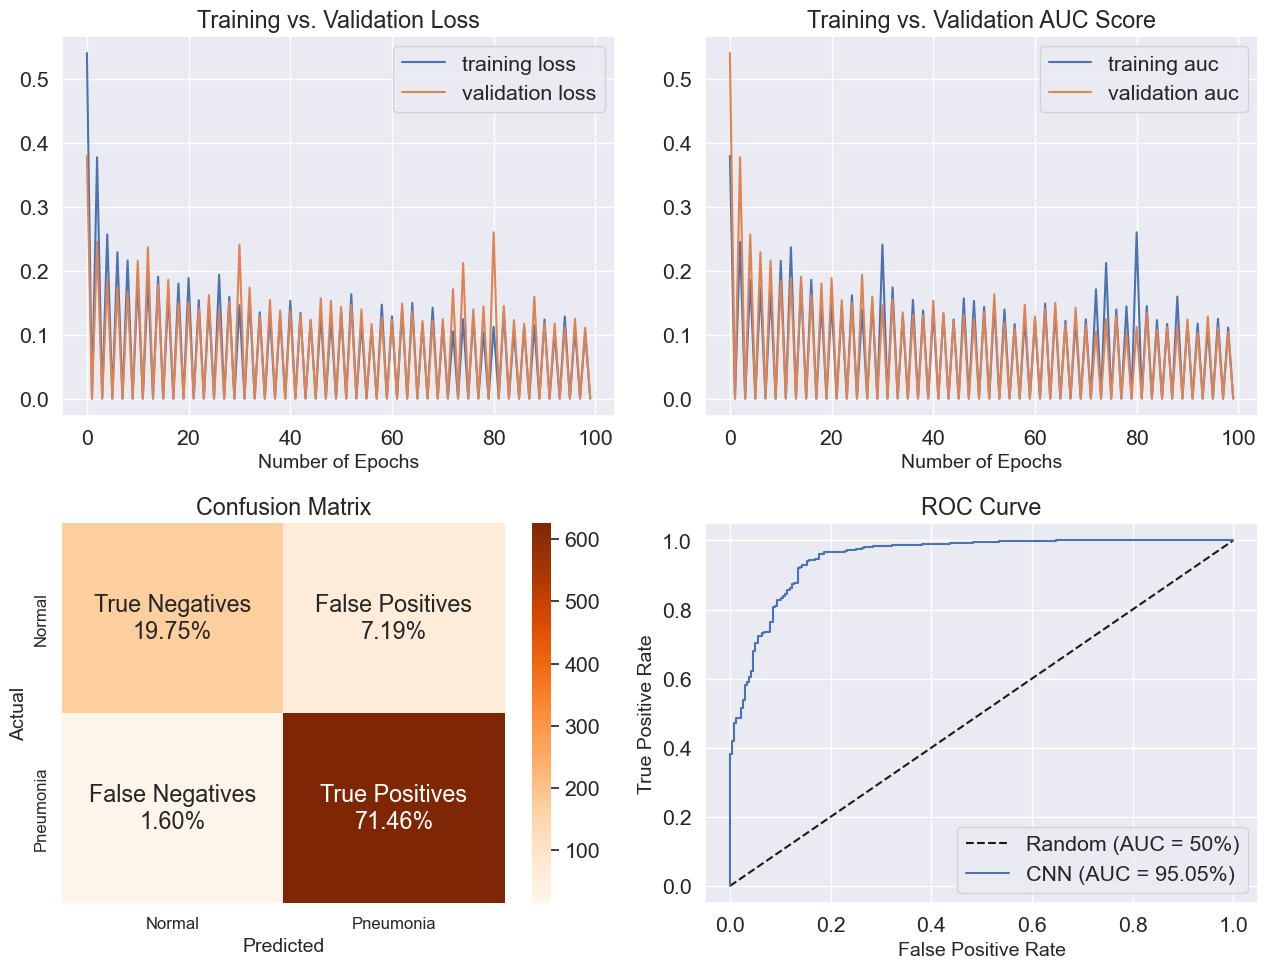

In [12]:
create_charts(cnn, cnn_model)

In [13]:
#Model 4(a)
# Conv2D x 3 + 128 dense units
hyper_feature_maps = 32
cnn = Sequential()
cnn.add(InputLayer(shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 100, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=2)

Epoch 1/100
33/33 - 27s - 821ms/step - auc_3: 0.5823 - loss: 0.5776 - val_auc_3: 0.9505 - val_loss: 0.5462
Epoch 2/100
33/33 - 0s - 415us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100


2024-03-30 19:44:07.015555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/freazx/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-30 19:44:07.019583: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 727ms/step - auc_3: 0.8968 - loss: 0.3906 - val_auc_3: 0.9565 - val_loss: 0.2435
Epoch 4/100
33/33 - 0s - 249us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/100


2024-03-30 19:44:31.033066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:44:31.035675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_3: 0.9459 - loss: 0.2701 - val_auc_3: 0.9601 - val_loss: 0.2414
Epoch 6/100
33/33 - 0s - 223us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/100


2024-03-30 19:44:54.984780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:44:54.987175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 729ms/step - auc_3: 0.9578 - loss: 0.2389 - val_auc_3: 0.9736 - val_loss: 0.4142
Epoch 8/100
33/33 - 0s - 518us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/100


2024-03-30 19:45:19.058353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:45:19.061985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 730ms/step - auc_3: 0.9628 - loss: 0.2198 - val_auc_3: 0.9772 - val_loss: 0.2071
Epoch 10/100
33/33 - 0s - 227us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/100


2024-03-30 19:45:43.164179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:45:43.166880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 728ms/step - auc_3: 0.9632 - loss: 0.2233 - val_auc_3: 0.9775 - val_loss: 0.1743
Epoch 12/100
33/33 - 0s - 223us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/100


2024-03-30 19:46:07.193689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:46:07.196347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 731ms/step - auc_3: 0.9662 - loss: 0.2055 - val_auc_3: 0.9738 - val_loss: 0.4626
Epoch 14/100
33/33 - 0s - 259us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 15/100


2024-03-30 19:46:31.331746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:46:31.334915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 812ms/step - auc_3: 0.9669 - loss: 0.2044 - val_auc_3: 0.9809 - val_loss: 0.3195
Epoch 16/100
33/33 - 0s - 324us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 17/100


2024-03-30 19:46:58.149330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:46:58.152910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 821ms/step - auc_3: 0.9739 - loss: 0.1816 - val_auc_3: 0.9810 - val_loss: 0.3146
Epoch 18/100
33/33 - 0s - 232us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/100


2024-03-30 19:47:25.250590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:47:25.253239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 776ms/step - auc_3: 0.9703 - loss: 0.1914 - val_auc_3: 0.9799 - val_loss: 0.2477
Epoch 20/100
33/33 - 0s - 314us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 21/100


2024-03-30 19:47:50.885330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:47:50.888989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 741ms/step - auc_3: 0.9777 - loss: 0.1676 - val_auc_3: 0.9799 - val_loss: 0.2725
Epoch 22/100
33/33 - 0s - 233us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 23/100


2024-03-30 19:48:15.336694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:48:15.339344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 741ms/step - auc_3: 0.9773 - loss: 0.1690 - val_auc_3: 0.9818 - val_loss: 0.1699
Epoch 24/100
33/33 - 0s - 252us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 25/100


2024-03-30 19:48:39.812851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:48:39.815721: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 736ms/step - auc_3: 0.9806 - loss: 0.1554 - val_auc_3: 0.9842 - val_loss: 0.1366
Epoch 26/100
33/33 - 0s - 229us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 27/100


2024-03-30 19:49:04.112601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:49:04.115186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 735ms/step - auc_3: 0.9812 - loss: 0.1681 - val_auc_3: 0.9842 - val_loss: 0.1321
Epoch 28/100
33/33 - 0s - 243us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 29/100


2024-03-30 19:49:28.378575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:49:28.381600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 736ms/step - auc_3: 0.9817 - loss: 0.1511 - val_auc_3: 0.9827 - val_loss: 0.1718
Epoch 30/100
33/33 - 0s - 235us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 31/100


2024-03-30 19:49:52.692936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:49:52.695772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 742ms/step - auc_3: 0.9753 - loss: 0.1720 - val_auc_3: 0.9830 - val_loss: 0.1411
Epoch 32/100
33/33 - 0s - 269us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 33/100


2024-03-30 19:50:17.206573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:50:17.209804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 741ms/step - auc_3: 0.9810 - loss: 0.1515 - val_auc_3: 0.9862 - val_loss: 0.1372
Epoch 34/100
33/33 - 0s - 239us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 35/100


2024-03-30 19:50:41.667082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:50:41.669739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 734ms/step - auc_3: 0.9842 - loss: 0.1574 - val_auc_3: 0.9858 - val_loss: 0.1677
Epoch 36/100
33/33 - 0s - 253us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 37/100


2024-03-30 19:51:05.910669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:51:05.913119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 736ms/step - auc_3: 0.9819 - loss: 0.1515 - val_auc_3: 0.9839 - val_loss: 0.1327
Epoch 38/100
33/33 - 0s - 363us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 39/100


2024-03-30 19:51:30.211313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:51:30.215477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 741ms/step - auc_3: 0.9798 - loss: 0.1731 - val_auc_3: 0.9836 - val_loss: 0.1405
Epoch 40/100
33/33 - 0s - 230us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 41/100


2024-03-30 19:51:54.665002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:51:54.667587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 736ms/step - auc_3: 0.9837 - loss: 0.1392 - val_auc_3: 0.9840 - val_loss: 0.1360
Epoch 42/100
33/33 - 0s - 227us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 43/100


2024-03-30 19:52:18.967158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:52:18.969771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 739ms/step - auc_3: 0.9855 - loss: 0.1334 - val_auc_3: 0.9862 - val_loss: 0.1266
Epoch 44/100
33/33 - 0s - 233us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 45/100


2024-03-30 19:52:43.354461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:52:43.357217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 755ms/step - auc_3: 0.9875 - loss: 0.1225 - val_auc_3: 0.9835 - val_loss: 0.1382
Epoch 46/100
33/33 - 0s - 282us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 47/100


2024-03-30 19:53:08.291173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:53:08.294651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 739ms/step - auc_3: 0.9866 - loss: 0.1278 - val_auc_3: 0.9843 - val_loss: 0.1734
Epoch 48/100
33/33 - 0s - 223us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 49/100


2024-03-30 19:53:32.674354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:53:32.676995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 734ms/step - auc_3: 0.9841 - loss: 0.1460 - val_auc_3: 0.9841 - val_loss: 0.1253
Epoch 50/100
33/33 - 0s - 222us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 51/100


2024-03-30 19:53:56.913891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:53:56.916592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 742ms/step - auc_3: 0.9865 - loss: 0.1260 - val_auc_3: 0.9839 - val_loss: 0.1506
Epoch 52/100
33/33 - 0s - 226us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 53/100


2024-03-30 19:54:21.401671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:54:21.404279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 734ms/step - auc_3: 0.9879 - loss: 0.1185 - val_auc_3: 0.9831 - val_loss: 0.1378
Epoch 54/100
33/33 - 0s - 234us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 55/100


2024-03-30 19:54:45.628130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:54:45.630843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 802ms/step - auc_3: 0.9845 - loss: 0.1343 - val_auc_3: 0.9869 - val_loss: 0.1721
Epoch 56/100
33/33 - 0s - 382us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 57/100


2024-03-30 19:55:12.093308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:55:12.098324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 763ms/step - auc_3: 0.9863 - loss: 0.1280 - val_auc_3: 0.9836 - val_loss: 0.1292
Epoch 58/100
33/33 - 0s - 236us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 59/100


2024-03-30 19:55:37.277568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:55:37.280231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 773ms/step - auc_3: 0.9846 - loss: 0.1368 - val_auc_3: 0.9840 - val_loss: 0.1311
Epoch 60/100
33/33 - 0s - 277us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 61/100


2024-03-30 19:56:02.798831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:56:02.801979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 796ms/step - auc_3: 0.9866 - loss: 0.1288 - val_auc_3: 0.9832 - val_loss: 0.1300
Epoch 62/100
33/33 - 0s - 241us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 63/100


2024-03-30 19:56:29.090571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:56:29.093529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 814ms/step - auc_3: 0.9854 - loss: 0.1283 - val_auc_3: 0.9826 - val_loss: 0.1287
Epoch 64/100
33/33 - 0s - 421us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 65/100


2024-03-30 19:56:55.976929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:56:55.982150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 28s - 861ms/step - auc_3: 0.9886 - loss: 0.1166 - val_auc_3: 0.9828 - val_loss: 0.1305
Epoch 66/100
33/33 - 0s - 334us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 67/100


2024-03-30 19:57:24.391082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:57:24.395483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 786ms/step - auc_3: 0.9849 - loss: 0.1398 - val_auc_3: 0.9830 - val_loss: 0.1906
Epoch 68/100
33/33 - 0s - 295us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 69/100


2024-03-30 19:57:50.355560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:57:50.359169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 771ms/step - auc_3: 0.9820 - loss: 0.1452 - val_auc_3: 0.9846 - val_loss: 0.1263
Epoch 70/100
33/33 - 0s - 267us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 71/100


2024-03-30 19:58:15.811954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:58:15.815453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 28s - 834ms/step - auc_3: 0.9861 - loss: 0.1367 - val_auc_3: 0.9833 - val_loss: 0.1611
Epoch 72/100
33/33 - 0s - 444us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 73/100


2024-03-30 19:58:43.340917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:58:43.345490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 28s - 837ms/step - auc_3: 0.9855 - loss: 0.1317 - val_auc_3: 0.9818 - val_loss: 0.1469
Epoch 74/100
33/33 - 0s - 423us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 75/100


2024-03-30 19:59:10.983786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:59:10.987176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 782ms/step - auc_3: 0.9816 - loss: 0.1564 - val_auc_3: 0.9817 - val_loss: 0.1475
Epoch 76/100
33/33 - 0s - 245us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 77/100


2024-03-30 19:59:36.804557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 19:59:36.807489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 775ms/step - auc_3: 0.9885 - loss: 0.1182 - val_auc_3: 0.9845 - val_loss: 0.1257
Epoch 78/100
33/33 - 0s - 275us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 79/100


2024-03-30 20:00:02.375858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:00:02.379179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_3: 0.9863 - loss: 0.1306 - val_auc_3: 0.9845 - val_loss: 0.1423
Epoch 80/100
33/33 - 0s - 266us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 81/100


2024-03-30 20:00:26.304007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:00:26.307123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 730ms/step - auc_3: 0.9899 - loss: 0.1176 - val_auc_3: 0.9861 - val_loss: 0.1279
Epoch 82/100
33/33 - 0s - 229us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 83/100


2024-03-30 20:00:50.405864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:00:50.408571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_3: 0.9893 - loss: 0.1179 - val_auc_3: 0.9823 - val_loss: 0.1486
Epoch 84/100
33/33 - 0s - 228us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 85/100


2024-03-30 20:01:14.326960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:01:14.329764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 729ms/step - auc_3: 0.9855 - loss: 0.1300 - val_auc_3: 0.9874 - val_loss: 0.1214
Epoch 86/100
33/33 - 0s - 234us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 87/100


2024-03-30 20:01:38.379088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:01:38.382029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 730ms/step - auc_3: 0.9866 - loss: 0.1348 - val_auc_3: 0.9869 - val_loss: 0.1348
Epoch 88/100
33/33 - 0s - 256us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 89/100


2024-03-30 20:02:02.491834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:02:02.494787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 728ms/step - auc_3: 0.9877 - loss: 0.1215 - val_auc_3: 0.9861 - val_loss: 0.1270
Epoch 90/100
33/33 - 0s - 238us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 91/100


2024-03-30 20:02:26.541010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:02:26.543816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 729ms/step - auc_3: 0.9879 - loss: 0.1238 - val_auc_3: 0.9807 - val_loss: 0.1433
Epoch 92/100
33/33 - 0s - 224us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 93/100


2024-03-30 20:02:50.620488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:02:50.622956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 728ms/step - auc_3: 0.9899 - loss: 0.1052 - val_auc_3: 0.9813 - val_loss: 0.1340
Epoch 94/100
33/33 - 0s - 248us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 95/100


2024-03-30 20:03:14.666265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:03:14.669126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 731ms/step - auc_3: 0.9927 - loss: 0.0918 - val_auc_3: 0.9849 - val_loss: 0.1236
Epoch 96/100
33/33 - 0s - 244us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 97/100


2024-03-30 20:03:38.798930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:03:38.801588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 728ms/step - auc_3: 0.9911 - loss: 0.1032 - val_auc_3: 0.9829 - val_loss: 0.1261
Epoch 98/100
33/33 - 0s - 213us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 99/100


2024-03-30 20:04:02.835924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:04:02.838471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 732ms/step - auc_3: 0.9902 - loss: 0.1038 - val_auc_3: 0.9850 - val_loss: 0.1220
Epoch 100/100
33/33 - 0s - 249us/step - auc_3: 0.0000e+00 - loss: 0.0000e+00 - val_auc_3: 0.0000e+00 - val_loss: 0.0000e+00


2024-03-30 20:04:26.996977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:04:27.000282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step
[Summary Statistics]
Accuracy = 93.04% | Precision = 93.14% | Recall = 97.66% | Specificity = 80.51% | F1 Score = 95.35%


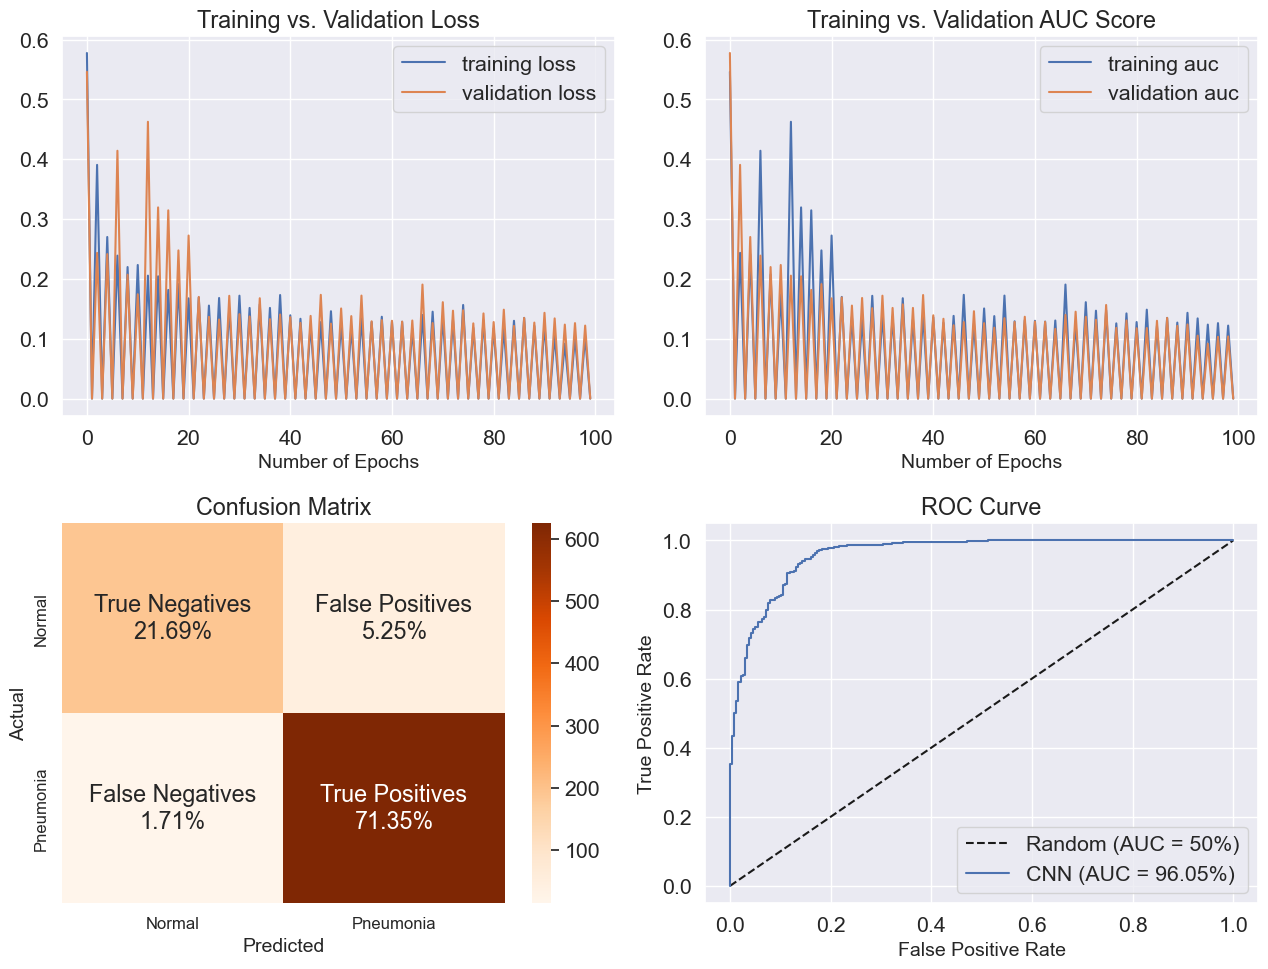

In [14]:
create_charts(cnn, cnn_model)

In [15]:
# Model 4 (b): Conv2D x 3 + 128 dense units (200 epochs)
hyper_feature_maps = 32
cnn = Sequential()
cnn.add(InputLayer(shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=hyper_feature_maps, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units=128))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 200, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=2)

Epoch 1/200
33/33 - 27s - 805ms/step - auc_4: 0.5182 - loss: 0.5870 - val_auc_4: 0.7845 - val_loss: 0.5572
Epoch 2/200
33/33 - 0s - 402us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/200


2024-03-30 20:09:19.695610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/freazx/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-30 20:09:19.699564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 721ms/step - auc_4: 0.8060 - loss: 0.4957 - val_auc_4: 0.9456 - val_loss: 0.3117
Epoch 4/200
33/33 - 0s - 244us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/200


2024-03-30 20:09:43.511978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:09:43.514760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 723ms/step - auc_4: 0.9266 - loss: 0.3083 - val_auc_4: 0.9556 - val_loss: 0.2497
Epoch 6/200
33/33 - 0s - 228us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/200


2024-03-30 20:10:07.385434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:10:07.388039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 722ms/step - auc_4: 0.9492 - loss: 0.2492 - val_auc_4: 0.9657 - val_loss: 0.3699
Epoch 8/200
33/33 - 0s - 219us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/200


2024-03-30 20:10:31.218143: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:10:31.220712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_4: 0.9626 - loss: 0.2131 - val_auc_4: 0.9749 - val_loss: 0.2388
Epoch 10/200
33/33 - 0s - 218us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/200


2024-03-30 20:10:55.146713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:10:55.149268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 722ms/step - auc_4: 0.9656 - loss: 0.2092 - val_auc_4: 0.9794 - val_loss: 0.3142
Epoch 12/200
33/33 - 0s - 217us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/200


2024-03-30 20:11:18.985118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:11:18.987735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 727ms/step - auc_4: 0.9728 - loss: 0.1884 - val_auc_4: 0.9794 - val_loss: 0.3706
Epoch 14/200
33/33 - 0s - 228us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 15/200


2024-03-30 20:11:42.994281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:11:42.996929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 724ms/step - auc_4: 0.9758 - loss: 0.1800 - val_auc_4: 0.9818 - val_loss: 0.2455
Epoch 16/200
33/33 - 0s - 223us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 17/200


2024-03-30 20:12:06.909374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:12:06.911967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 727ms/step - auc_4: 0.9731 - loss: 0.1835 - val_auc_4: 0.9827 - val_loss: 0.2060
Epoch 18/200
33/33 - 0s - 232us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/200


2024-03-30 20:12:30.908558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:12:30.911476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 728ms/step - auc_4: 0.9793 - loss: 0.1603 - val_auc_4: 0.9856 - val_loss: 0.1704
Epoch 20/200
33/33 - 0s - 220us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 21/200


2024-03-30 20:12:54.956734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:12:54.959258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 726ms/step - auc_4: 0.9784 - loss: 0.1645 - val_auc_4: 0.9814 - val_loss: 0.2538
Epoch 22/200
33/33 - 0s - 226us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 23/200


2024-03-30 20:13:18.936606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:13:18.939268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 724ms/step - auc_4: 0.9774 - loss: 0.1779 - val_auc_4: 0.9842 - val_loss: 0.1413
Epoch 24/200
33/33 - 0s - 225us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 25/200


2024-03-30 20:13:42.836015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:13:42.838635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 727ms/step - auc_4: 0.9819 - loss: 0.1477 - val_auc_4: 0.9860 - val_loss: 0.1434
Epoch 26/200
33/33 - 0s - 217us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 27/200


2024-03-30 20:14:06.820796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:14:06.823323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 724ms/step - auc_4: 0.9811 - loss: 0.1518 - val_auc_4: 0.9854 - val_loss: 0.1565
Epoch 28/200
33/33 - 0s - 224us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 29/200


2024-03-30 20:14:30.718074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:14:30.720785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_4: 0.9852 - loss: 0.1342 - val_auc_4: 0.9859 - val_loss: 0.1895
Epoch 30/200
33/33 - 0s - 217us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 31/200


2024-03-30 20:14:54.657778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:14:54.660309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 723ms/step - auc_4: 0.9835 - loss: 0.1416 - val_auc_4: 0.9848 - val_loss: 0.1501
Epoch 32/200
33/33 - 0s - 228us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 33/200


2024-03-30 20:15:18.516335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:15:18.518998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 727ms/step - auc_4: 0.9847 - loss: 0.1529 - val_auc_4: 0.9848 - val_loss: 0.1777
Epoch 34/200
33/33 - 0s - 232us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 35/200


2024-03-30 20:15:42.505567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:15:42.508179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_4: 0.9786 - loss: 0.1653 - val_auc_4: 0.9846 - val_loss: 0.1554
Epoch 36/200
33/33 - 0s - 214us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 37/200


2024-03-30 20:16:06.438156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:16:06.440805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 727ms/step - auc_4: 0.9826 - loss: 0.1516 - val_auc_4: 0.9867 - val_loss: 0.1322
Epoch 38/200
33/33 - 0s - 212us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 39/200


2024-03-30 20:16:30.444973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:16:30.447457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 722ms/step - auc_4: 0.9841 - loss: 0.1391 - val_auc_4: 0.9840 - val_loss: 0.1367
Epoch 40/200
33/33 - 0s - 214us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 41/200


2024-03-30 20:16:54.274409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:16:54.277003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 729ms/step - auc_4: 0.9837 - loss: 0.1405 - val_auc_4: 0.9831 - val_loss: 0.1423
Epoch 42/200
33/33 - 0s - 226us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 43/200


2024-03-30 20:17:18.339352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:17:18.342167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 723ms/step - auc_4: 0.9846 - loss: 0.1343 - val_auc_4: 0.9861 - val_loss: 0.1271
Epoch 44/200
33/33 - 0s - 234us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 45/200


2024-03-30 20:17:42.223153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:17:42.225953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 729ms/step - auc_4: 0.9861 - loss: 0.1331 - val_auc_4: 0.9855 - val_loss: 0.1479
Epoch 46/200
33/33 - 0s - 219us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 47/200


2024-03-30 20:18:06.297126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:18:06.299738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 727ms/step - auc_4: 0.9864 - loss: 0.1328 - val_auc_4: 0.9871 - val_loss: 0.1259
Epoch 48/200
33/33 - 0s - 212us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 49/200


2024-03-30 20:18:30.293832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:18:30.296392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 727ms/step - auc_4: 0.9870 - loss: 0.1239 - val_auc_4: 0.9867 - val_loss: 0.1299
Epoch 50/200
33/33 - 0s - 232us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 51/200


2024-03-30 20:18:54.305213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:18:54.308020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 726ms/step - auc_4: 0.9879 - loss: 0.1197 - val_auc_4: 0.9872 - val_loss: 0.1220
Epoch 52/200
33/33 - 0s - 229us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 53/200


2024-03-30 20:19:18.279537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:19:18.282028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_4: 0.9890 - loss: 0.1116 - val_auc_4: 0.9856 - val_loss: 0.1422
Epoch 54/200
33/33 - 0s - 222us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 55/200


2024-03-30 20:19:42.221410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:19:42.223853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 727ms/step - auc_4: 0.9857 - loss: 0.1358 - val_auc_4: 0.9855 - val_loss: 0.1380
Epoch 56/200
33/33 - 0s - 243us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 57/200


2024-03-30 20:20:06.224144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:20:06.227288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 729ms/step - auc_4: 0.9859 - loss: 0.1287 - val_auc_4: 0.9861 - val_loss: 0.1275
Epoch 58/200
33/33 - 0s - 237us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 59/200


2024-03-30 20:20:30.280948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:20:30.283720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 724ms/step - auc_4: 0.9897 - loss: 0.1111 - val_auc_4: 0.9849 - val_loss: 0.1392
Epoch 60/200
33/33 - 0s - 225us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 61/200


2024-03-30 20:20:54.195228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:20:54.197814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 727ms/step - auc_4: 0.9816 - loss: 0.1535 - val_auc_4: 0.9828 - val_loss: 0.1430
Epoch 62/200
33/33 - 0s - 239us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 63/200


2024-03-30 20:21:18.209159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:21:18.212110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 722ms/step - auc_4: 0.9855 - loss: 0.1319 - val_auc_4: 0.9845 - val_loss: 0.1284
Epoch 64/200
33/33 - 0s - 233us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 65/200


2024-03-30 20:21:42.047243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:21:42.049749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_4: 0.9883 - loss: 0.1171 - val_auc_4: 0.9866 - val_loss: 0.1250
Epoch 66/200
33/33 - 0s - 232us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 67/200


2024-03-30 20:22:05.971552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:22:05.974039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 726ms/step - auc_4: 0.9883 - loss: 0.1171 - val_auc_4: 0.9811 - val_loss: 0.1355
Epoch 68/200
33/33 - 0s - 220us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 69/200


2024-03-30 20:22:29.952442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:22:29.955033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 729ms/step - auc_4: 0.9878 - loss: 0.1159 - val_auc_4: 0.9871 - val_loss: 0.1298
Epoch 70/200
33/33 - 0s - 214us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 71/200


2024-03-30 20:22:54.017586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:22:54.020265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 726ms/step - auc_4: 0.9915 - loss: 0.1005 - val_auc_4: 0.9850 - val_loss: 0.1261
Epoch 72/200
33/33 - 0s - 227us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 73/200


2024-03-30 20:23:17.975919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:23:17.978670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 728ms/step - auc_4: 0.9901 - loss: 0.1056 - val_auc_4: 0.9882 - val_loss: 0.1365
Epoch 74/200
33/33 - 0s - 222us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 75/200


2024-03-30 20:23:42.018993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:23:42.021848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_4: 0.9904 - loss: 0.1069 - val_auc_4: 0.9862 - val_loss: 0.1319
Epoch 76/200
33/33 - 0s - 211us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 77/200


2024-03-30 20:24:05.942935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:24:05.945472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 726ms/step - auc_4: 0.9909 - loss: 0.1049 - val_auc_4: 0.9877 - val_loss: 0.1198
Epoch 78/200
33/33 - 0s - 246us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 79/200


2024-03-30 20:24:29.910718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:24:29.913745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 726ms/step - auc_4: 0.9898 - loss: 0.1100 - val_auc_4: 0.9828 - val_loss: 0.1303
Epoch 80/200
33/33 - 0s - 239us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 81/200


2024-03-30 20:24:53.876446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:24:53.879040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 726ms/step - auc_4: 0.9906 - loss: 0.1010 - val_auc_4: 0.9831 - val_loss: 0.1333
Epoch 82/200
33/33 - 0s - 244us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 83/200


2024-03-30 20:25:17.830521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:25:17.833106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 732ms/step - auc_4: 0.9884 - loss: 0.1179 - val_auc_4: 0.9874 - val_loss: 0.1329
Epoch 84/200
33/33 - 0s - 600us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 85/200


2024-03-30 20:25:42.005869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:25:42.012601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 726ms/step - auc_4: 0.9894 - loss: 0.1099 - val_auc_4: 0.9887 - val_loss: 0.1130
Epoch 86/200
33/33 - 0s - 238us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 87/200


2024-03-30 20:26:06.004118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:26:06.006982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 723ms/step - auc_4: 0.9894 - loss: 0.1111 - val_auc_4: 0.9820 - val_loss: 0.1351
Epoch 88/200
33/33 - 0s - 214us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 89/200


2024-03-30 20:26:29.860565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:26:29.863137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_4: 0.9906 - loss: 0.1081 - val_auc_4: 0.9864 - val_loss: 0.1374
Epoch 90/200
33/33 - 0s - 223us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 91/200


2024-03-30 20:26:53.796878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:26:53.799413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_4: 0.9889 - loss: 0.1173 - val_auc_4: 0.9849 - val_loss: 0.1276
Epoch 92/200
33/33 - 0s - 227us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 93/200


2024-03-30 20:27:17.723834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:27:17.726480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_4: 0.9905 - loss: 0.1170 - val_auc_4: 0.9898 - val_loss: 0.1393
Epoch 94/200
33/33 - 0s - 214us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 95/200


2024-03-30 20:27:41.657650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:27:41.660221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 724ms/step - auc_4: 0.9841 - loss: 0.1381 - val_auc_4: 0.9843 - val_loss: 0.1299
Epoch 96/200
33/33 - 0s - 249us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 97/200


2024-03-30 20:28:05.567858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:28:05.570524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 728ms/step - auc_4: 0.9880 - loss: 0.1222 - val_auc_4: 0.9884 - val_loss: 0.1197
Epoch 98/200
33/33 - 0s - 229us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 99/200


2024-03-30 20:28:29.586099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:28:29.589009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 727ms/step - auc_4: 0.9903 - loss: 0.1104 - val_auc_4: 0.9879 - val_loss: 0.1250
Epoch 100/200
33/33 - 0s - 224us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 101/200


2024-03-30 20:28:53.579765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:28:53.582407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 729ms/step - auc_4: 0.9907 - loss: 0.1054 - val_auc_4: 0.9870 - val_loss: 0.1348
Epoch 102/200
33/33 - 0s - 241us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 103/200


2024-03-30 20:29:17.651946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:29:17.654694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 724ms/step - auc_4: 0.9907 - loss: 0.1110 - val_auc_4: 0.9877 - val_loss: 0.1245
Epoch 104/200
33/33 - 0s - 243us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 105/200


2024-03-30 20:29:41.566654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:29:41.569471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 726ms/step - auc_4: 0.9882 - loss: 0.1268 - val_auc_4: 0.9856 - val_loss: 0.1410
Epoch 106/200
33/33 - 0s - 220us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 107/200


2024-03-30 20:30:05.530699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:30:05.533416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 728ms/step - auc_4: 0.9908 - loss: 0.1064 - val_auc_4: 0.9855 - val_loss: 0.1297
Epoch 108/200
33/33 - 0s - 230us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 109/200


2024-03-30 20:30:29.573090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:30:29.576004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 728ms/step - auc_4: 0.9901 - loss: 0.1229 - val_auc_4: 0.9872 - val_loss: 0.1325
Epoch 110/200
33/33 - 0s - 219us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 111/200


2024-03-30 20:30:53.601009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:30:53.603514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 736ms/step - auc_4: 0.9913 - loss: 0.0989 - val_auc_4: 0.9856 - val_loss: 0.1271
Epoch 112/200
33/33 - 0s - 221us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 113/200


2024-03-30 20:31:17.896183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:31:17.898692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 729ms/step - auc_4: 0.9926 - loss: 0.0891 - val_auc_4: 0.9887 - val_loss: 0.1223
Epoch 114/200
33/33 - 0s - 219us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 115/200


2024-03-30 20:31:41.948395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:31:41.951161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 726ms/step - auc_4: 0.9914 - loss: 0.0942 - val_auc_4: 0.9873 - val_loss: 0.1072
Epoch 116/200
33/33 - 0s - 221us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 117/200


2024-03-30 20:32:05.916684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:32:05.919338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 729ms/step - auc_4: 0.9894 - loss: 0.1218 - val_auc_4: 0.9865 - val_loss: 0.1367
Epoch 118/200
33/33 - 0s - 217us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 119/200


2024-03-30 20:32:29.994728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:32:29.997295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 729ms/step - auc_4: 0.9903 - loss: 0.1033 - val_auc_4: 0.9871 - val_loss: 0.1208
Epoch 120/200
33/33 - 0s - 213us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 121/200


2024-03-30 20:32:54.048709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:32:54.051197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 727ms/step - auc_4: 0.9939 - loss: 0.0854 - val_auc_4: 0.9869 - val_loss: 0.1179
Epoch 122/200
33/33 - 0s - 226us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 123/200


2024-03-30 20:33:18.042390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:33:18.045077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 726ms/step - auc_4: 0.9925 - loss: 0.0918 - val_auc_4: 0.9899 - val_loss: 0.1268
Epoch 124/200
33/33 - 0s - 211us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 125/200


2024-03-30 20:33:42.006189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:33:42.008672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 730ms/step - auc_4: 0.9924 - loss: 0.0946 - val_auc_4: 0.9891 - val_loss: 0.1052
Epoch 126/200
33/33 - 0s - 226us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 127/200


2024-03-30 20:34:06.114664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:34:06.117321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 726ms/step - auc_4: 0.9916 - loss: 0.0968 - val_auc_4: 0.9898 - val_loss: 0.1087
Epoch 128/200
33/33 - 0s - 213us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 129/200


2024-03-30 20:34:30.083244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:34:30.085825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 41s - 1s/step - auc_4: 0.9909 - loss: 0.0992 - val_auc_4: 0.9886 - val_loss: 0.1183
Epoch 130/200
33/33 - 0s - 227us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 131/200


2024-03-30 20:35:11.274207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:35:11.276869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 729ms/step - auc_4: 0.9930 - loss: 0.0874 - val_auc_4: 0.9848 - val_loss: 0.1348
Epoch 132/200
33/33 - 0s - 224us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 133/200


2024-03-30 20:35:35.343460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:35:35.345991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_4: 0.9929 - loss: 0.0863 - val_auc_4: 0.9909 - val_loss: 0.1059
Epoch 134/200
33/33 - 0s - 237us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 135/200


2024-03-30 20:35:59.291053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:35:59.293676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 726ms/step - auc_4: 0.9938 - loss: 0.0891 - val_auc_4: 0.9918 - val_loss: 0.1152
Epoch 136/200
33/33 - 0s - 213us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 137/200


2024-03-30 20:36:23.251239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:36:23.253826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 730ms/step - auc_4: 0.9913 - loss: 0.1032 - val_auc_4: 0.9874 - val_loss: 0.1165
Epoch 138/200
33/33 - 0s - 231us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 139/200


2024-03-30 20:36:47.335035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:36:47.337655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 736ms/step - auc_4: 0.9927 - loss: 0.0935 - val_auc_4: 0.9860 - val_loss: 0.1167
Epoch 140/200
33/33 - 0s - 213us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 141/200


2024-03-30 20:37:11.645194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:37:11.647630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 727ms/step - auc_4: 0.9924 - loss: 0.0901 - val_auc_4: 0.9909 - val_loss: 0.1034
Epoch 142/200
33/33 - 0s - 228us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 143/200


2024-03-30 20:37:35.629881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:37:35.632768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 727ms/step - auc_4: 0.9937 - loss: 0.0837 - val_auc_4: 0.9906 - val_loss: 0.1261
Epoch 144/200
33/33 - 0s - 228us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 145/200


2024-03-30 20:37:59.622402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:37:59.624967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 724ms/step - auc_4: 0.9932 - loss: 0.0910 - val_auc_4: 0.9873 - val_loss: 0.1078
Epoch 146/200
33/33 - 0s - 221us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 147/200


2024-03-30 20:38:23.534651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:38:23.537083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 728ms/step - auc_4: 0.9946 - loss: 0.0803 - val_auc_4: 0.9877 - val_loss: 0.1045
Epoch 148/200
33/33 - 0s - 214us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 149/200


2024-03-30 20:38:47.561330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:38:47.563992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 730ms/step - auc_4: 0.9933 - loss: 0.0897 - val_auc_4: 0.9899 - val_loss: 0.1164
Epoch 150/200
33/33 - 0s - 227us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 151/200


2024-03-30 20:39:11.675852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:39:11.678323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 727ms/step - auc_4: 0.9937 - loss: 0.0838 - val_auc_4: 0.9904 - val_loss: 0.1107
Epoch 152/200
33/33 - 0s - 212us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 153/200


2024-03-30 20:39:35.677788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:39:35.680337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 729ms/step - auc_4: 0.9938 - loss: 0.0847 - val_auc_4: 0.9895 - val_loss: 0.1044
Epoch 154/200
33/33 - 0s - 214us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 155/200


2024-03-30 20:39:59.739876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:39:59.742331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 726ms/step - auc_4: 0.9942 - loss: 0.0850 - val_auc_4: 0.9881 - val_loss: 0.1170
Epoch 156/200
33/33 - 0s - 219us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 157/200


2024-03-30 20:40:23.710807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:40:23.713454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 727ms/step - auc_4: 0.9936 - loss: 0.0861 - val_auc_4: 0.9895 - val_loss: 0.1088
Epoch 158/200
33/33 - 0s - 215us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 159/200


2024-03-30 20:40:47.707474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:40:47.710035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 722ms/step - auc_4: 0.9947 - loss: 0.0797 - val_auc_4: 0.9870 - val_loss: 0.1139
Epoch 160/200
33/33 - 0s - 213us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 161/200


2024-03-30 20:41:11.555080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:41:11.557749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 724ms/step - auc_4: 0.9922 - loss: 0.1053 - val_auc_4: 0.9905 - val_loss: 0.2558
Epoch 162/200
33/33 - 0s - 228us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 163/200


2024-03-30 20:41:35.466198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:41:35.469018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 726ms/step - auc_4: 0.9919 - loss: 0.0965 - val_auc_4: 0.9890 - val_loss: 0.1020
Epoch 164/200
33/33 - 0s - 214us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 165/200


2024-03-30 20:41:59.438816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:41:59.441511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 729ms/step - auc_4: 0.9890 - loss: 0.1168 - val_auc_4: 0.9876 - val_loss: 0.1398
Epoch 166/200
33/33 - 0s - 209us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 167/200


2024-03-30 20:42:23.504734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:42:23.507044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_4: 0.9938 - loss: 0.0869 - val_auc_4: 0.9875 - val_loss: 0.1144
Epoch 168/200
33/33 - 0s - 230us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 169/200


2024-03-30 20:42:47.436685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:42:47.439186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 734ms/step - auc_4: 0.9923 - loss: 0.0952 - val_auc_4: 0.9886 - val_loss: 0.1173
Epoch 170/200
33/33 - 0s - 225us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 171/200


2024-03-30 20:43:11.655293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:43:11.657712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 730ms/step - auc_4: 0.9929 - loss: 0.0885 - val_auc_4: 0.9902 - val_loss: 0.1009
Epoch 172/200
33/33 - 0s - 211us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 173/200


2024-03-30 20:43:35.741264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:43:35.743656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 728ms/step - auc_4: 0.9927 - loss: 0.0886 - val_auc_4: 0.9897 - val_loss: 0.1172
Epoch 174/200
33/33 - 0s - 216us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 175/200


2024-03-30 20:43:59.772954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:43:59.775670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 726ms/step - auc_4: 0.9934 - loss: 0.0859 - val_auc_4: 0.9911 - val_loss: 0.1041
Epoch 176/200
33/33 - 0s - 227us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 177/200


2024-03-30 20:44:23.725265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:44:23.728009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 723ms/step - auc_4: 0.9936 - loss: 0.0856 - val_auc_4: 0.9909 - val_loss: 0.1108
Epoch 178/200
33/33 - 0s - 220us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 179/200


2024-03-30 20:44:47.608664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:44:47.611271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_4: 0.9947 - loss: 0.0794 - val_auc_4: 0.9879 - val_loss: 0.1183
Epoch 180/200
33/33 - 0s - 247us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 181/200


2024-03-30 20:45:11.532088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:45:11.535178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 731ms/step - auc_4: 0.9942 - loss: 0.0852 - val_auc_4: 0.9880 - val_loss: 0.1067
Epoch 182/200
33/33 - 0s - 213us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 183/200


2024-03-30 20:45:35.660757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:45:35.663312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_4: 0.9944 - loss: 0.0825 - val_auc_4: 0.9884 - val_loss: 0.1105
Epoch 184/200
33/33 - 0s - 221us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 185/200


2024-03-30 20:45:59.601636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:45:59.604374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 726ms/step - auc_4: 0.9936 - loss: 0.0848 - val_auc_4: 0.9883 - val_loss: 0.0982
Epoch 186/200
33/33 - 0s - 232us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 187/200


2024-03-30 20:46:23.572280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:46:23.574971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_4: 0.9951 - loss: 0.0753 - val_auc_4: 0.9910 - val_loss: 0.1611
Epoch 188/200
33/33 - 0s - 219us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 189/200


2024-03-30 20:46:47.495068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:46:47.497788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 728ms/step - auc_4: 0.9940 - loss: 0.0846 - val_auc_4: 0.9915 - val_loss: 0.0901
Epoch 190/200
33/33 - 0s - 221us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 191/200


2024-03-30 20:47:11.545457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:47:11.548174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_4: 0.9949 - loss: 0.0792 - val_auc_4: 0.9903 - val_loss: 0.1055
Epoch 192/200
33/33 - 0s - 209us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 193/200


2024-03-30 20:47:35.466735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:47:35.469375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 730ms/step - auc_4: 0.9901 - loss: 0.1043 - val_auc_4: 0.9915 - val_loss: 0.0954
Epoch 194/200
33/33 - 0s - 208us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 195/200


2024-03-30 20:47:59.557887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:47:59.560317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 731ms/step - auc_4: 0.9941 - loss: 0.0825 - val_auc_4: 0.9898 - val_loss: 0.1094
Epoch 196/200
33/33 - 0s - 216us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 197/200


2024-03-30 20:48:23.681140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:48:23.683774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 725ms/step - auc_4: 0.9944 - loss: 0.0788 - val_auc_4: 0.9887 - val_loss: 0.1119
Epoch 198/200
33/33 - 0s - 218us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 199/200


2024-03-30 20:48:47.628471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:48:47.631047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 24s - 728ms/step - auc_4: 0.9956 - loss: 0.0721 - val_auc_4: 0.9903 - val_loss: 0.0977
Epoch 200/200
33/33 - 0s - 216us/step - auc_4: 0.0000e+00 - loss: 0.0000e+00 - val_auc_4: 0.0000e+00 - val_loss: 0.0000e+00


2024-03-30 20:49:11.665116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:49:11.667659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step
[Summary Statistics]
Accuracy = 91.55% | Precision = 91.62% | Recall = 97.34% | Specificity = 75.85% | F1 Score = 94.39%


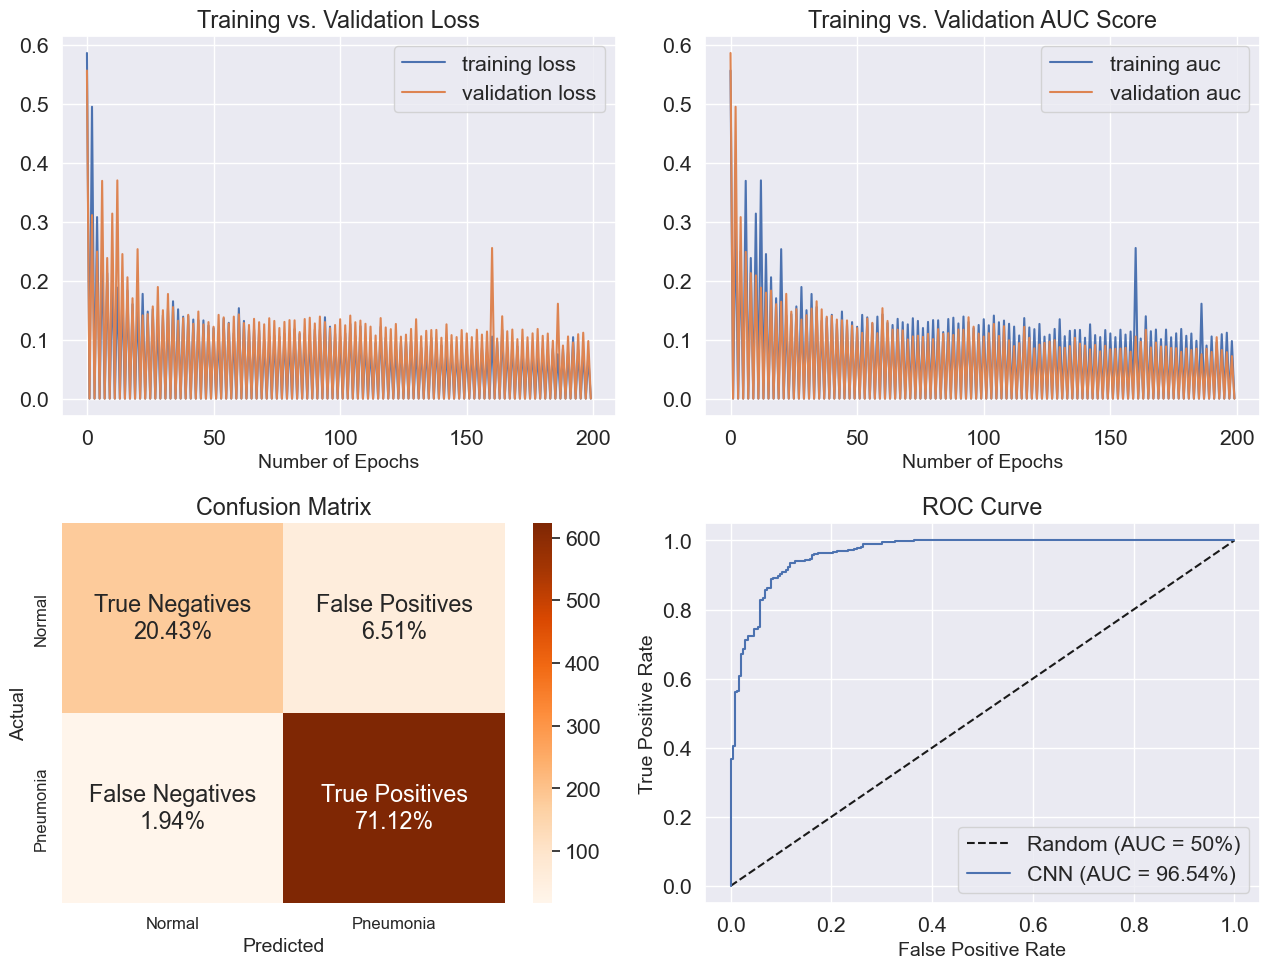

In [16]:
create_charts(cnn, cnn_model)

In [17]:
#Model 5: batch size: 64 Conv2D (filter: 32, 64, 128)  x 3 + different dense units + Batch Normalization
cnn = Sequential()
cnn.add(InputLayer(shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=64, kernel_size=3))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=128, kernel_size=3))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Flatten())

cnn.add(BatchNormalization())
cnn.add(Dense(activation='relu', units=1024))
cnn.add(Dense(activation='relu', units=512))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 100, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=2)

Epoch 1/100
33/33 - 28s - 834ms/step - auc_5: 0.9488 - loss: 0.3077 - val_auc_5: 0.9180 - val_loss: 0.6092
Epoch 2/100
33/33 - 0s - 401us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100


2024-03-30 20:51:36.593944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/freazx/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-30 20:51:36.597795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 752ms/step - auc_5: 0.9761 - loss: 0.1722 - val_auc_5: 0.9772 - val_loss: 0.6365
Epoch 4/100
33/33 - 0s - 243us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/100


2024-03-30 20:52:01.412532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:52:01.415533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 756ms/step - auc_5: 0.9817 - loss: 0.1482 - val_auc_5: 0.9434 - val_loss: 0.6129
Epoch 6/100
33/33 - 0s - 249us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/100


2024-03-30 20:52:26.362054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:52:26.364804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 751ms/step - auc_5: 0.9855 - loss: 0.1371 - val_auc_5: 0.9791 - val_loss: 0.4676
Epoch 8/100
33/33 - 0s - 233us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/100


2024-03-30 20:52:51.170018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:52:51.172765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 756ms/step - auc_5: 0.9862 - loss: 0.1339 - val_auc_5: 0.9695 - val_loss: 0.4843
Epoch 10/100
33/33 - 0s - 244us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/100


2024-03-30 20:53:16.113107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:53:16.115835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 759ms/step - auc_5: 0.9890 - loss: 0.1126 - val_auc_5: 0.9853 - val_loss: 0.4626
Epoch 12/100
33/33 - 0s - 220us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/100


2024-03-30 20:53:41.170756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:53:41.173315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 758ms/step - auc_5: 0.9901 - loss: 0.1069 - val_auc_5: 0.9853 - val_loss: 0.3544
Epoch 14/100
33/33 - 0s - 229us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 15/100


2024-03-30 20:54:06.190444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:54:06.192908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 754ms/step - auc_5: 0.9902 - loss: 0.1068 - val_auc_5: 0.9882 - val_loss: 0.3453
Epoch 16/100
33/33 - 0s - 220us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 17/100


2024-03-30 20:54:31.075822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:54:31.078336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 760ms/step - auc_5: 0.9866 - loss: 0.1287 - val_auc_5: 0.9810 - val_loss: 0.4404
Epoch 18/100
33/33 - 0s - 220us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/100


2024-03-30 20:54:56.159169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:54:56.161590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 763ms/step - auc_5: 0.9927 - loss: 0.0909 - val_auc_5: 0.9910 - val_loss: 0.2933
Epoch 20/100
33/33 - 0s - 223us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 21/100


2024-03-30 20:55:21.334665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:55:21.337403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 774ms/step - auc_5: 0.9940 - loss: 0.0837 - val_auc_5: 0.9868 - val_loss: 0.2254
Epoch 22/100
33/33 - 0s - 239us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 23/100


2024-03-30 20:55:46.898493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:55:46.901255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 800ms/step - auc_5: 0.9926 - loss: 0.0914 - val_auc_5: 0.9818 - val_loss: 0.3550
Epoch 24/100
33/33 - 0s - 835us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 25/100


2024-03-30 20:56:13.300724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:56:13.304531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 795ms/step - auc_5: 0.9926 - loss: 0.0854 - val_auc_5: 0.9813 - val_loss: 0.2224
Epoch 26/100
33/33 - 0s - 251us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 27/100


2024-03-30 20:56:39.568577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:56:39.571569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 775ms/step - auc_5: 0.9942 - loss: 0.0922 - val_auc_5: 0.9803 - val_loss: 0.2706
Epoch 28/100
33/33 - 0s - 244us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 29/100


2024-03-30 20:57:05.158323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:57:05.161330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 776ms/step - auc_5: 0.9904 - loss: 0.1053 - val_auc_5: 0.9718 - val_loss: 0.6682
Epoch 30/100
33/33 - 0s - 251us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 31/100


2024-03-30 20:57:30.781947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:57:30.784997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 767ms/step - auc_5: 0.9957 - loss: 0.0704 - val_auc_5: 0.9901 - val_loss: 0.2145
Epoch 32/100
33/33 - 0s - 229us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 33/100


2024-03-30 20:57:56.102229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:57:56.104723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 770ms/step - auc_5: 0.9947 - loss: 0.0884 - val_auc_5: 0.9748 - val_loss: 0.2705
Epoch 34/100
33/33 - 0s - 230us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 35/100


2024-03-30 20:58:21.511754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:58:21.514297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 771ms/step - auc_5: 0.9896 - loss: 0.1255 - val_auc_5: 0.8657 - val_loss: 1.0280
Epoch 36/100
33/33 - 0s - 227us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 37/100


2024-03-30 20:58:46.958765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:58:46.961539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 775ms/step - auc_5: 0.9924 - loss: 0.1015 - val_auc_5: 0.9917 - val_loss: 0.1346
Epoch 38/100
33/33 - 0s - 243us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 39/100


2024-03-30 20:59:12.538781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:59:12.541473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 771ms/step - auc_5: 0.9936 - loss: 0.0822 - val_auc_5: 0.9915 - val_loss: 0.1311
Epoch 40/100
33/33 - 0s - 248us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 41/100


2024-03-30 20:59:38.007596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 20:59:38.010261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 772ms/step - auc_5: 0.9958 - loss: 0.0684 - val_auc_5: 0.9840 - val_loss: 0.1186
Epoch 42/100
33/33 - 0s - 233us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 43/100


2024-03-30 21:00:03.510919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:00:03.513845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 775ms/step - auc_5: 0.9968 - loss: 0.0588 - val_auc_5: 0.9880 - val_loss: 0.1201
Epoch 44/100
33/33 - 0s - 232us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 45/100


2024-03-30 21:00:29.084404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:00:29.087098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 771ms/step - auc_5: 0.9947 - loss: 0.0665 - val_auc_5: 0.9687 - val_loss: 0.1752
Epoch 46/100
33/33 - 0s - 229us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 47/100


2024-03-30 21:00:54.535884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:00:54.538630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 777ms/step - auc_5: 0.9962 - loss: 0.0608 - val_auc_5: 0.9709 - val_loss: 0.1570
Epoch 48/100
33/33 - 0s - 214us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 49/100


2024-03-30 21:01:20.195090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:01:20.197638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 775ms/step - auc_5: 0.9972 - loss: 0.0545 - val_auc_5: 0.9516 - val_loss: 0.2764
Epoch 50/100
33/33 - 0s - 231us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 51/100


2024-03-30 21:01:45.763788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:01:45.766328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 772ms/step - auc_5: 0.9962 - loss: 0.0628 - val_auc_5: 0.9721 - val_loss: 0.1852
Epoch 52/100
33/33 - 0s - 223us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 53/100


2024-03-30 21:02:11.257656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:02:11.260164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 778ms/step - auc_5: 0.9935 - loss: 0.0950 - val_auc_5: 0.9701 - val_loss: 0.2555
Epoch 54/100
33/33 - 0s - 234us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 55/100


2024-03-30 21:02:36.949013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:02:36.951702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 771ms/step - auc_5: 0.9961 - loss: 0.0564 - val_auc_5: 0.9630 - val_loss: 0.6641
Epoch 56/100
33/33 - 0s - 235us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 57/100


2024-03-30 21:03:02.392436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:03:02.395161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 775ms/step - auc_5: 0.9980 - loss: 0.0471 - val_auc_5: 0.9544 - val_loss: 0.2528
Epoch 58/100
33/33 - 0s - 217us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 59/100


2024-03-30 21:03:27.972360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:03:27.974854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 25s - 771ms/step - auc_5: 0.9973 - loss: 0.0700 - val_auc_5: 0.7512 - val_loss: 4.2847
Epoch 60/100
33/33 - 0s - 234us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 61/100


2024-03-30 21:03:53.436635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:03:53.439323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 775ms/step - auc_5: 0.9904 - loss: 0.1079 - val_auc_5: 0.9763 - val_loss: 0.2633
Epoch 62/100
33/33 - 0s - 217us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 63/100


2024-03-30 21:04:19.007060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:04:19.009648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 773ms/step - auc_5: 0.9949 - loss: 0.0750 - val_auc_5: 0.8630 - val_loss: 2.1917
Epoch 64/100
33/33 - 0s - 233us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 65/100


2024-03-30 21:04:44.541692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:04:44.544283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 777ms/step - auc_5: 0.9976 - loss: 0.0538 - val_auc_5: 0.9893 - val_loss: 0.1233
Epoch 66/100
33/33 - 0s - 229us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 67/100


2024-03-30 21:05:10.195012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:05:10.197674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 779ms/step - auc_5: 0.9977 - loss: 0.0433 - val_auc_5: 0.9753 - val_loss: 0.4470
Epoch 68/100
33/33 - 0s - 240us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 69/100


2024-03-30 21:05:35.916493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:05:35.919216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 28s - 845ms/step - auc_5: 0.9976 - loss: 0.0398 - val_auc_5: 0.9882 - val_loss: 0.1222
Epoch 70/100
33/33 - 0s - 318us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 71/100


2024-03-30 21:06:03.825245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:06:03.829189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 828ms/step - auc_5: 0.9983 - loss: 0.0382 - val_auc_5: 0.9837 - val_loss: 0.1852
Epoch 72/100
33/33 - 0s - 227us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 73/100


2024-03-30 21:06:31.155724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:06:31.158290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 832ms/step - auc_5: 0.9983 - loss: 0.0367 - val_auc_5: 0.9755 - val_loss: 0.3475
Epoch 74/100
33/33 - 0s - 325us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 75/100


2024-03-30 21:06:58.633670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:06:58.636750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 28s - 838ms/step - auc_5: 0.9964 - loss: 0.0537 - val_auc_5: 0.9725 - val_loss: 0.1811
Epoch 76/100
33/33 - 0s - 235us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 77/100


2024-03-30 21:07:26.302947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:07:26.305669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 28s - 848ms/step - auc_5: 0.9962 - loss: 0.0713 - val_auc_5: 0.8973 - val_loss: 0.6710
Epoch 78/100
33/33 - 0s - 339us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 79/100


2024-03-30 21:07:54.310864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:07:54.315437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 29s - 874ms/step - auc_5: 0.9950 - loss: 0.0690 - val_auc_5: 0.9350 - val_loss: 0.5398
Epoch 80/100
33/33 - 0s - 441us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 81/100


2024-03-30 21:08:23.165237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:08:23.168477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 28s - 839ms/step - auc_5: 0.9972 - loss: 0.0554 - val_auc_5: 0.9820 - val_loss: 0.3267
Epoch 82/100
33/33 - 0s - 238us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 83/100


2024-03-30 21:08:50.882844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:08:50.885926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 796ms/step - auc_5: 0.9975 - loss: 0.0464 - val_auc_5: 0.9830 - val_loss: 0.1542
Epoch 84/100
33/33 - 0s - 307us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 85/100


2024-03-30 21:09:17.148649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:09:17.152293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 788ms/step - auc_5: 0.9981 - loss: 0.0405 - val_auc_5: 0.9799 - val_loss: 0.2867
Epoch 86/100
33/33 - 0s - 237us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 87/100


2024-03-30 21:09:43.155632: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:09:43.158247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 794ms/step - auc_5: 0.9989 - loss: 0.0284 - val_auc_5: 0.9798 - val_loss: 0.1842
Epoch 88/100
33/33 - 0s - 240us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 89/100


2024-03-30 21:10:09.374277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:10:09.376939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 826ms/step - auc_5: 0.9995 - loss: 0.0244 - val_auc_5: 0.9845 - val_loss: 0.2395
Epoch 90/100
33/33 - 0s - 577us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 91/100


2024-03-30 21:10:36.634171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:10:36.637839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 30s - 900ms/step - auc_5: 0.9997 - loss: 0.0189 - val_auc_5: 0.9764 - val_loss: 0.2021
Epoch 92/100
33/33 - 0s - 466us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 93/100


2024-03-30 21:11:06.368027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:11:06.372428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 28s - 858ms/step - auc_5: 0.9997 - loss: 0.0204 - val_auc_5: 0.9612 - val_loss: 0.3413
Epoch 94/100
33/33 - 0s - 240us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 95/100


2024-03-30 21:11:34.684848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:11:34.687685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 29s - 872ms/step - auc_5: 0.9986 - loss: 0.0357 - val_auc_5: 0.9550 - val_loss: 0.2623
Epoch 96/100
33/33 - 0s - 302us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 97/100


2024-03-30 21:12:03.466395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:12:03.469842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 28s - 848ms/step - auc_5: 0.9959 - loss: 0.0618 - val_auc_5: 0.9192 - val_loss: 0.5871
Epoch 98/100
33/33 - 0s - 341us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 99/100


2024-03-30 21:12:31.465823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:12:31.470059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 28s - 852ms/step - auc_5: 0.9984 - loss: 0.0390 - val_auc_5: 0.9651 - val_loss: 0.2598
Epoch 100/100
33/33 - 0s - 232us/step - auc_5: 0.0000e+00 - loss: 0.0000e+00 - val_auc_5: 0.0000e+00 - val_loss: 0.0000e+00


2024-03-30 21:12:59.585500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:12:59.588221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step
[Summary Statistics]
Accuracy = 81.85% | Precision = 80.25% | Recall = 99.69% | Specificity = 33.47% | F1 Score = 88.92%


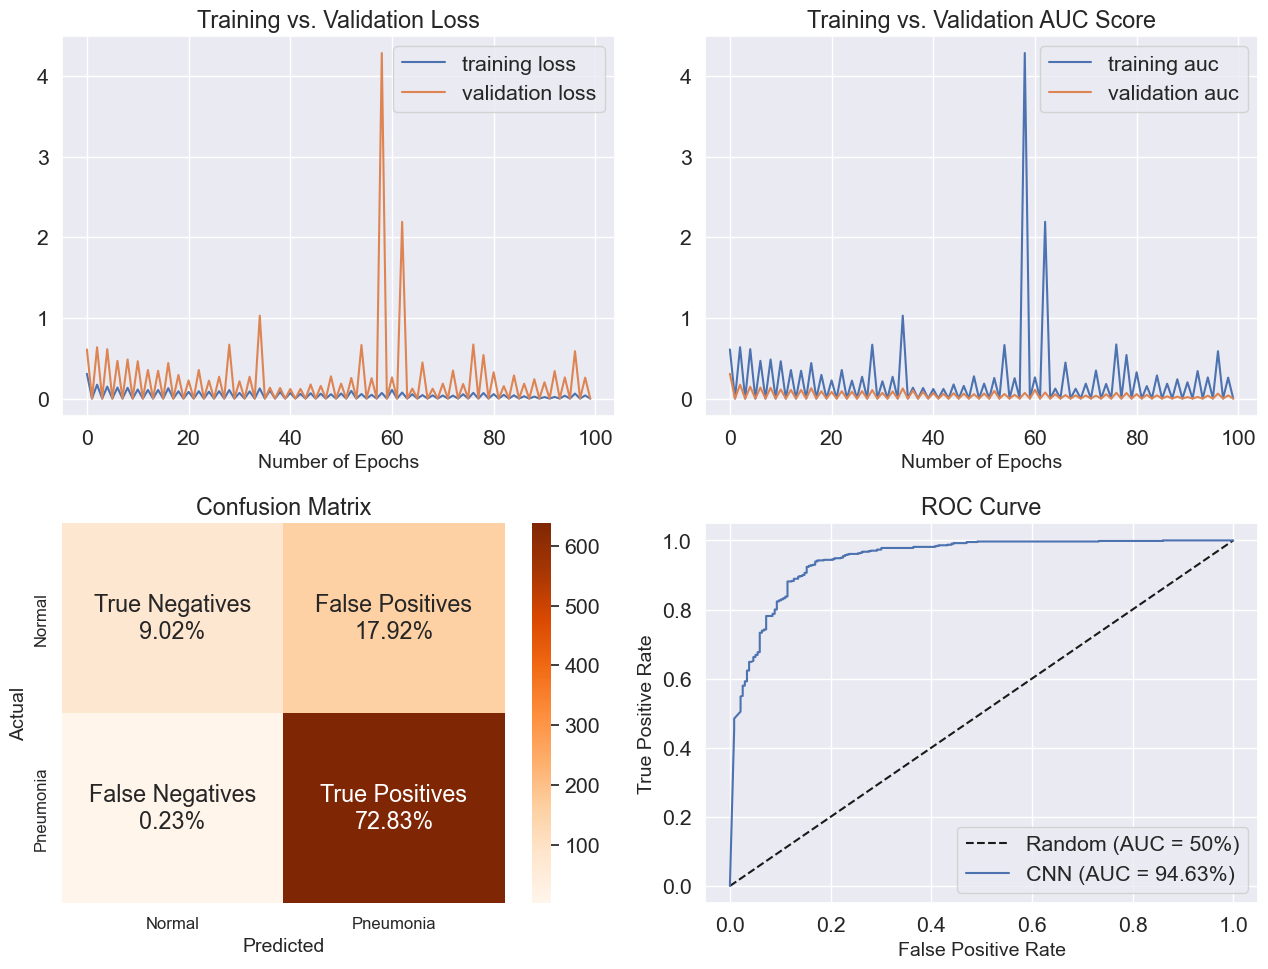

In [18]:
create_charts(cnn, cnn_model)

In [19]:
#Model 6: Conv2D (filter: 32, 64, 128)  x 3 + different dense units + Batch Normalization + Dropout Dense layer
cnn = Sequential()
cnn.add(InputLayer(shape=(hyper_dimension, hyper_dimension, hyper_channels)))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='elu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(filters=64, kernel_size=3, activation='elu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.3))

cnn.add(Conv2D(filters=128, kernel_size=3, activation='elu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.3))

cnn.add(Flatten())

cnn.add(BatchNormalization())
cnn.add(Dense(activation='relu', units=512))
cnn.add(Dropout(0.25))
cnn.add(Dense(activation='relu', units=256))
cnn.add(Dropout(0.25))
cnn.add(Dense(activation='sigmoid', units=1))

cnn.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[AUC()])
cnn_model = cnn.fit(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 100, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=2)

Epoch 1/100
33/33 - 29s - 887ms/step - auc_6: 0.8033 - loss: 0.4947 - val_auc_6: 0.8760 - val_loss: 0.6327
Epoch 2/100
33/33 - 0s - 436us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100


2024-03-30 21:13:43.178889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/freazx/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-30 21:13:43.183033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 798ms/step - auc_6: 0.9224 - loss: 0.3143 - val_auc_6: 0.9467 - val_loss: 0.5965
Epoch 4/100
33/33 - 0s - 266us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/100


2024-03-30 21:14:09.541889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:14:09.544639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 802ms/step - auc_6: 0.9409 - loss: 0.2703 - val_auc_6: 0.9504 - val_loss: 0.5175
Epoch 6/100
33/33 - 0s - 247us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/100


2024-03-30 21:14:36.017779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:14:36.020476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 802ms/step - auc_6: 0.9529 - loss: 0.2475 - val_auc_6: 0.9742 - val_loss: 0.5556
Epoch 8/100
33/33 - 0s - 243us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/100


2024-03-30 21:15:02.501385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:15:02.503900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 807ms/step - auc_6: 0.9556 - loss: 0.2334 - val_auc_6: 0.9667 - val_loss: 0.4689
Epoch 10/100
33/33 - 0s - 267us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/100


2024-03-30 21:15:29.148512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:15:29.151714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 813ms/step - auc_6: 0.9677 - loss: 0.2073 - val_auc_6: 0.9776 - val_loss: 0.4005
Epoch 12/100
33/33 - 0s - 256us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/100


2024-03-30 21:15:55.992024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:15:55.994954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 805ms/step - auc_6: 0.9694 - loss: 0.2011 - val_auc_6: 0.9680 - val_loss: 0.4252
Epoch 14/100
33/33 - 0s - 255us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 15/100


2024-03-30 21:16:22.561934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:16:22.565094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 810ms/step - auc_6: 0.9718 - loss: 0.1841 - val_auc_6: 0.9767 - val_loss: 0.4027
Epoch 16/100
33/33 - 0s - 231us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 17/100


2024-03-30 21:16:49.295620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:16:49.298192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 813ms/step - auc_6: 0.9689 - loss: 0.1998 - val_auc_6: 0.9809 - val_loss: 0.5311
Epoch 18/100
33/33 - 0s - 240us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/100


2024-03-30 21:17:16.146711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:17:16.149255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 817ms/step - auc_6: 0.9766 - loss: 0.1655 - val_auc_6: 0.9773 - val_loss: 0.3158
Epoch 20/100
33/33 - 0s - 235us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 21/100


2024-03-30 21:17:43.107959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:17:43.110933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 828ms/step - auc_6: 0.9762 - loss: 0.1690 - val_auc_6: 0.9799 - val_loss: 0.2453
Epoch 22/100
33/33 - 0s - 242us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 23/100


2024-03-30 21:18:10.435726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:18:10.438801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 820ms/step - auc_6: 0.9795 - loss: 0.1655 - val_auc_6: 0.9809 - val_loss: 0.2515
Epoch 24/100
33/33 - 0s - 236us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 25/100


2024-03-30 21:18:37.517263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:18:37.519972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 811ms/step - auc_6: 0.9824 - loss: 0.1471 - val_auc_6: 0.9837 - val_loss: 0.1979
Epoch 26/100
33/33 - 0s - 246us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 27/100


2024-03-30 21:19:04.292838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:19:04.295672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 817ms/step - auc_6: 0.9798 - loss: 0.1573 - val_auc_6: 0.9837 - val_loss: 0.2080
Epoch 28/100
33/33 - 0s - 251us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 29/100


2024-03-30 21:19:31.259304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:19:31.261879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 816ms/step - auc_6: 0.9781 - loss: 0.1757 - val_auc_6: 0.9818 - val_loss: 0.1813
Epoch 30/100
33/33 - 0s - 276us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 31/100


2024-03-30 21:19:58.188162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:19:58.191478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 823ms/step - auc_6: 0.9795 - loss: 0.1636 - val_auc_6: 0.9837 - val_loss: 0.2040
Epoch 32/100
33/33 - 0s - 290us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 33/100


2024-03-30 21:20:25.365509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:20:25.368863: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 829ms/step - auc_6: 0.9787 - loss: 0.1549 - val_auc_6: 0.9721 - val_loss: 0.1909
Epoch 34/100
33/33 - 0s - 248us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 35/100


2024-03-30 21:20:52.733111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:20:52.735960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 822ms/step - auc_6: 0.9823 - loss: 0.1457 - val_auc_6: 0.9824 - val_loss: 0.1637
Epoch 36/100
33/33 - 0s - 260us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 37/100


2024-03-30 21:21:19.878461: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:21:19.881375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 819ms/step - auc_6: 0.9818 - loss: 0.1496 - val_auc_6: 0.9877 - val_loss: 0.1666
Epoch 38/100
33/33 - 0s - 244us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 39/100


2024-03-30 21:21:46.929280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:21:46.931973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 813ms/step - auc_6: 0.9831 - loss: 0.1402 - val_auc_6: 0.9874 - val_loss: 0.1500
Epoch 40/100
33/33 - 0s - 246us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 41/100


2024-03-30 21:22:13.766602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:22:13.769399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 813ms/step - auc_6: 0.9825 - loss: 0.1451 - val_auc_6: 0.9897 - val_loss: 0.1392
Epoch 42/100
33/33 - 0s - 249us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 43/100


2024-03-30 21:22:40.619738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:22:40.622385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 819ms/step - auc_6: 0.9807 - loss: 0.1490 - val_auc_6: 0.9871 - val_loss: 0.1963
Epoch 44/100
33/33 - 0s - 239us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 45/100


2024-03-30 21:23:07.665693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:23:07.668326: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 28s - 863ms/step - auc_6: 0.9842 - loss: 0.1393 - val_auc_6: 0.9888 - val_loss: 0.2070
Epoch 46/100
33/33 - 0s - 306us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 47/100


2024-03-30 21:23:36.168401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:23:36.171704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 818ms/step - auc_6: 0.9871 - loss: 0.1241 - val_auc_6: 0.9877 - val_loss: 0.3079
Epoch 48/100
33/33 - 0s - 233us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 49/100


2024-03-30 21:24:03.169151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:24:03.171645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 803ms/step - auc_6: 0.9806 - loss: 0.1847 - val_auc_6: 0.9631 - val_loss: 0.2094
Epoch 50/100
33/33 - 0s - 234us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 51/100


2024-03-30 21:24:29.684492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:24:29.686969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 797ms/step - auc_6: 0.9823 - loss: 0.1466 - val_auc_6: 0.9796 - val_loss: 0.2695
Epoch 52/100
33/33 - 0s - 243us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 53/100


2024-03-30 21:24:56.000165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:24:56.003134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 800ms/step - auc_6: 0.9826 - loss: 0.1439 - val_auc_6: 0.9802 - val_loss: 0.1355
Epoch 54/100
33/33 - 0s - 241us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 55/100


2024-03-30 21:25:22.419413: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:25:22.422052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 802ms/step - auc_6: 0.9857 - loss: 0.1299 - val_auc_6: 0.9786 - val_loss: 0.1510
Epoch 56/100
33/33 - 0s - 235us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 57/100


2024-03-30 21:25:48.883274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:25:48.886007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 792ms/step - auc_6: 0.9787 - loss: 0.1731 - val_auc_6: 0.9806 - val_loss: 0.1394
Epoch 58/100
33/33 - 0s - 233us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 59/100


2024-03-30 21:26:15.032463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:26:15.035114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 793ms/step - auc_6: 0.9829 - loss: 0.1446 - val_auc_6: 0.9703 - val_loss: 0.1671
Epoch 60/100
33/33 - 0s - 228us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 61/100


2024-03-30 21:26:41.220424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:26:41.222969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 797ms/step - auc_6: 0.9841 - loss: 0.1391 - val_auc_6: 0.9829 - val_loss: 0.1638
Epoch 62/100
33/33 - 0s - 237us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 63/100


2024-03-30 21:27:07.520626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:27:07.523147: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 802ms/step - auc_6: 0.9859 - loss: 0.1290 - val_auc_6: 0.9875 - val_loss: 0.1246
Epoch 64/100
33/33 - 0s - 233us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 65/100


2024-03-30 21:27:34.006739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:27:34.009653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 797ms/step - auc_6: 0.9892 - loss: 0.1152 - val_auc_6: 0.9667 - val_loss: 0.2133
Epoch 66/100
33/33 - 0s - 242us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 67/100


2024-03-30 21:28:00.307782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:28:00.310471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 791ms/step - auc_6: 0.9875 - loss: 0.1223 - val_auc_6: 0.9770 - val_loss: 0.1639
Epoch 68/100
33/33 - 0s - 256us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 69/100


2024-03-30 21:28:26.419264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:28:26.422369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 791ms/step - auc_6: 0.9868 - loss: 0.1296 - val_auc_6: 0.9782 - val_loss: 0.1556
Epoch 70/100
33/33 - 0s - 227us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 71/100


2024-03-30 21:28:52.531792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:28:52.534382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 28s - 840ms/step - auc_6: 0.9876 - loss: 0.1237 - val_auc_6: 0.9713 - val_loss: 0.1671
Epoch 72/100
33/33 - 0s - 323us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 73/100


2024-03-30 21:29:20.272428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:29:20.276173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 812ms/step - auc_6: 0.9894 - loss: 0.1111 - val_auc_6: 0.9877 - val_loss: 0.2536
Epoch 74/100
33/33 - 0s - 232us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 75/100


2024-03-30 21:29:47.066075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:29:47.068812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 817ms/step - auc_6: 0.9887 - loss: 0.1142 - val_auc_6: 0.9842 - val_loss: 0.1497
Epoch 76/100
33/33 - 0s - 239us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 77/100


2024-03-30 21:30:14.031773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:30:14.034670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 815ms/step - auc_6: 0.9893 - loss: 0.1152 - val_auc_6: 0.9812 - val_loss: 0.1500
Epoch 78/100
33/33 - 0s - 244us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 79/100


2024-03-30 21:30:40.936210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:30:40.938928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 812ms/step - auc_6: 0.9881 - loss: 0.1146 - val_auc_6: 0.9820 - val_loss: 0.1362
Epoch 80/100
33/33 - 0s - 248us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 81/100


2024-03-30 21:31:07.727920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:31:07.730531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 806ms/step - auc_6: 0.9876 - loss: 0.1271 - val_auc_6: 0.9811 - val_loss: 0.1358
Epoch 82/100
33/33 - 0s - 230us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 83/100


2024-03-30 21:31:34.344906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:31:34.347579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 820ms/step - auc_6: 0.9880 - loss: 0.1167 - val_auc_6: 0.9903 - val_loss: 0.2160
Epoch 84/100
33/33 - 0s - 246us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 85/100


2024-03-30 21:32:01.406463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:32:01.409095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 809ms/step - auc_6: 0.9877 - loss: 0.1179 - val_auc_6: 0.9851 - val_loss: 0.1461
Epoch 86/100
33/33 - 0s - 235us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 87/100


2024-03-30 21:32:28.124712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:32:28.127430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 807ms/step - auc_6: 0.9900 - loss: 0.1064 - val_auc_6: 0.9885 - val_loss: 0.1272
Epoch 88/100
33/33 - 0s - 231us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 89/100


2024-03-30 21:32:54.770662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:32:54.773370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 806ms/step - auc_6: 0.9877 - loss: 0.1206 - val_auc_6: 0.9820 - val_loss: 0.1427
Epoch 90/100
33/33 - 0s - 247us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 91/100


2024-03-30 21:33:21.367069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:33:21.369968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 806ms/step - auc_6: 0.9861 - loss: 0.1313 - val_auc_6: 0.9883 - val_loss: 0.1161
Epoch 92/100
33/33 - 0s - 236us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 93/100


2024-03-30 21:33:47.968199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:33:47.970701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 805ms/step - auc_6: 0.9890 - loss: 0.1098 - val_auc_6: 0.9909 - val_loss: 0.1075
Epoch 94/100
33/33 - 0s - 247us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 95/100


2024-03-30 21:34:14.553378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:34:14.556098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 27s - 803ms/step - auc_6: 0.9879 - loss: 0.1129 - val_auc_6: 0.9831 - val_loss: 0.1351
Epoch 96/100
33/33 - 0s - 239us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 97/100


2024-03-30 21:34:41.071868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:34:41.074803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 801ms/step - auc_6: 0.9911 - loss: 0.1032 - val_auc_6: 0.9877 - val_loss: 0.1390
Epoch 98/100
33/33 - 0s - 242us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 99/100


2024-03-30 21:35:07.499298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:35:07.501923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 26s - 800ms/step - auc_6: 0.9900 - loss: 0.1105 - val_auc_6: 0.9734 - val_loss: 0.1641
Epoch 100/100
33/33 - 0s - 230us/step - auc_6: 0.0000e+00 - loss: 0.0000e+00 - val_auc_6: 0.0000e+00 - val_loss: 0.0000e+00


2024-03-30 21:35:33.912864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 21:35:33.915542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 356ms/step
[Summary Statistics]
Accuracy = 91.32% | Precision = 90.29% | Recall = 98.75% | Specificity = 71.19% | F1 Score = 94.33%


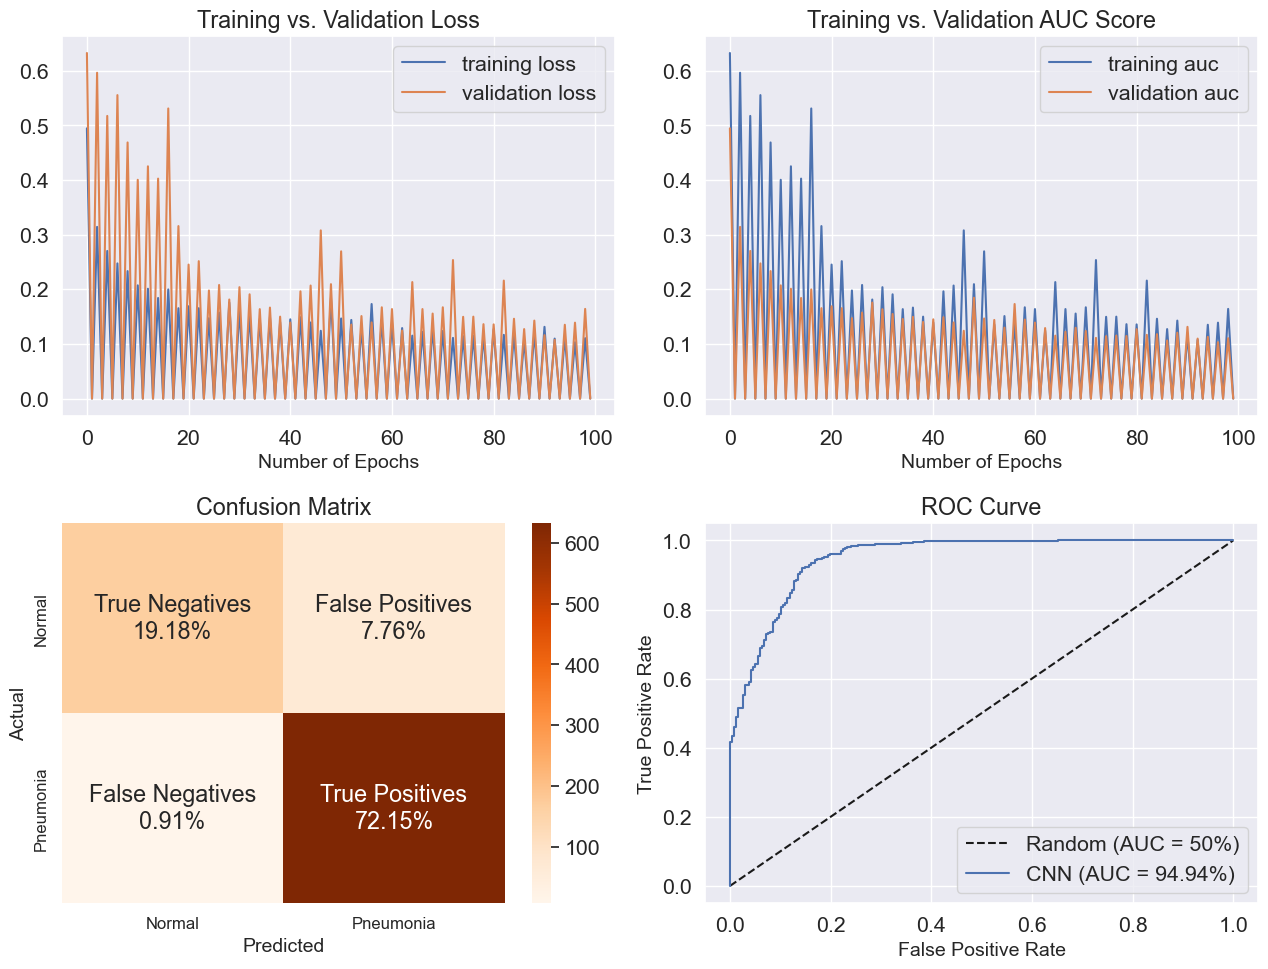

In [20]:
create_charts(cnn, cnn_model)

In [21]:
cnn = Sequential()

# Input layer (adjust based on your image size and channels)
cnn.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(hyper_dimension, hyper_dimension, hyper_channels)))  

# Convolutional layers with ReLU activation and MaxPooling
cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))  # Add dropout for regularization

cnn.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

# Flatten the output for feeding into dense layers
cnn.add(Flatten())

# Dense layers with ReLU activation
cnn.add(Dense(units=256, activation='relu'))
cnn.add(Dropout(0.5))  # Higher dropout for denser layers

# Output layer with sigmoid activation for binary classification (pneumonia vs. normal)
cnn.add(Dense(units=1, activation='sigmoid'))

# Compile the model
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC()])
cnn_model = cnn.fit(train_generator, 
                              steps_per_epoch = len(train_generator), 
                              epochs = 100, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=2)

/Users/freazx/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
33/33 - 32s - 972ms/step - auc_7: 0.5147 - loss: 0.6573 - val_auc_7: 0.6515 - val_loss: 0.5955
Epoch 2/100
33/33 - 0s - 421us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/100


2024-03-30 22:43:11.857553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/freazx/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-30 22:43:11.861268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 29s - 893ms/step - auc_7: 0.7264 - loss: 0.5147 - val_auc_7: 0.9448 - val_loss: 0.4979
Epoch 4/100
33/33 - 0s - 231us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/100


2024-03-30 22:43:41.336204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:43:41.338898: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 31s - 935ms/step - auc_7: 0.9198 - loss: 0.3165 - val_auc_7: 0.9692 - val_loss: 0.3474
Epoch 6/100
33/33 - 0s - 240us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/100


2024-03-30 22:44:12.190063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:44:12.192732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 32s - 970ms/step - auc_7: 0.9294 - loss: 0.2949 - val_auc_7: 0.9692 - val_loss: 0.2671
Epoch 8/100
33/33 - 0s - 243us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/100


2024-03-30 22:44:44.215793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:44:44.218480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 33s - 992ms/step - auc_7: 0.9531 - loss: 0.2436 - val_auc_7: 0.9726 - val_loss: 0.2385
Epoch 10/100
33/33 - 0s - 253us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/100


2024-03-30 22:45:16.959024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:45:16.961947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 33s - 992ms/step - auc_7: 0.9500 - loss: 0.2452 - val_auc_7: 0.9744 - val_loss: 0.2720
Epoch 12/100
33/33 - 0s - 250us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/100


2024-03-30 22:45:49.720480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:45:49.723181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 33s - 1s/step - auc_7: 0.9567 - loss: 0.2330 - val_auc_7: 0.9762 - val_loss: 0.2291
Epoch 14/100
33/33 - 0s - 250us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 15/100


2024-03-30 22:46:23.132630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:46:23.135424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9603 - loss: 0.2262 - val_auc_7: 0.9795 - val_loss: 0.1807
Epoch 16/100
33/33 - 0s - 248us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 17/100


2024-03-30 22:46:56.661069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:46:56.664086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 33s - 1s/step - auc_7: 0.9660 - loss: 0.2114 - val_auc_7: 0.9838 - val_loss: 0.2789
Epoch 18/100
33/33 - 0s - 257us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/100


2024-03-30 22:47:30.083739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:47:30.086705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9668 - loss: 0.2118 - val_auc_7: 0.9846 - val_loss: 0.1902
Epoch 20/100
33/33 - 0s - 254us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 21/100


2024-03-30 22:48:03.734883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:48:03.737896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9715 - loss: 0.2033 - val_auc_7: 0.9846 - val_loss: 0.1486
Epoch 22/100
33/33 - 0s - 252us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 23/100


2024-03-30 22:48:37.540704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:48:37.543672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9747 - loss: 0.1742 - val_auc_7: 0.9841 - val_loss: 0.1469
Epoch 24/100
33/33 - 0s - 250us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 25/100


2024-03-30 22:49:11.577994: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:49:11.580825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9752 - loss: 0.1779 - val_auc_7: 0.9811 - val_loss: 0.1536
Epoch 26/100
33/33 - 0s - 297us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 27/100


2024-03-30 22:49:46.140034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:49:46.143618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9780 - loss: 0.1627 - val_auc_7: 0.9867 - val_loss: 0.1301
Epoch 28/100
33/33 - 0s - 259us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 29/100


2024-03-30 22:50:20.743175: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:50:20.746281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9770 - loss: 0.1663 - val_auc_7: 0.9865 - val_loss: 0.1437
Epoch 30/100
33/33 - 0s - 266us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 31/100


2024-03-30 22:50:55.642108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:50:55.645391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9800 - loss: 0.1561 - val_auc_7: 0.9842 - val_loss: 0.1668
Epoch 32/100
33/33 - 0s - 257us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 33/100


2024-03-30 22:51:29.985168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:51:29.988121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9793 - loss: 0.1671 - val_auc_7: 0.9852 - val_loss: 0.1393
Epoch 34/100
33/33 - 0s - 254us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 35/100


2024-03-30 22:52:04.867726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:52:04.870749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9815 - loss: 0.1498 - val_auc_7: 0.9812 - val_loss: 0.1955
Epoch 36/100
33/33 - 0s - 266us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 37/100


2024-03-30 22:52:39.241392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:52:39.244553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9822 - loss: 0.1456 - val_auc_7: 0.9862 - val_loss: 0.1315
Epoch 38/100
33/33 - 0s - 247us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 39/100


2024-03-30 22:53:13.694171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:53:13.696954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9799 - loss: 0.1571 - val_auc_7: 0.9855 - val_loss: 0.1748
Epoch 40/100
33/33 - 0s - 254us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 41/100


2024-03-30 22:53:48.147279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:53:48.150074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9811 - loss: 0.1712 - val_auc_7: 0.9853 - val_loss: 0.1802
Epoch 42/100
33/33 - 0s - 278us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 43/100


2024-03-30 22:54:22.734762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:54:22.738054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9832 - loss: 0.1436 - val_auc_7: 0.9832 - val_loss: 0.1482
Epoch 44/100
33/33 - 0s - 252us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 45/100


2024-03-30 22:54:57.464755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:54:57.467821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9837 - loss: 0.1366 - val_auc_7: 0.9890 - val_loss: 0.1204
Epoch 46/100
33/33 - 0s - 248us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 47/100


2024-03-30 22:55:31.717477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:55:31.720394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9833 - loss: 0.1417 - val_auc_7: 0.9865 - val_loss: 0.1470
Epoch 48/100
33/33 - 0s - 246us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 49/100


2024-03-30 22:56:06.546912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:56:06.549800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9857 - loss: 0.1304 - val_auc_7: 0.9880 - val_loss: 0.1210
Epoch 50/100
33/33 - 0s - 258us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 51/100


2024-03-30 22:56:40.882887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:56:40.885886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9861 - loss: 0.1290 - val_auc_7: 0.9885 - val_loss: 0.1240
Epoch 52/100
33/33 - 0s - 257us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 53/100


2024-03-30 22:57:15.377257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:57:15.380256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9795 - loss: 0.1922 - val_auc_7: 0.9770 - val_loss: 0.2011
Epoch 54/100
33/33 - 0s - 247us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 55/100


2024-03-30 22:57:49.480154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:57:49.483137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9760 - loss: 0.1706 - val_auc_7: 0.9871 - val_loss: 0.1710
Epoch 56/100
33/33 - 0s - 238us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 57/100


2024-03-30 22:58:23.540671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:58:23.543402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9775 - loss: 0.1792 - val_auc_7: 0.9879 - val_loss: 0.1446
Epoch 58/100
33/33 - 0s - 251us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 59/100


2024-03-30 22:58:58.219214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:58:58.222066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9818 - loss: 0.1593 - val_auc_7: 0.9848 - val_loss: 0.1389
Epoch 60/100
33/33 - 0s - 240us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 61/100


2024-03-30 22:59:32.291538: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 22:59:32.294311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9841 - loss: 0.1366 - val_auc_7: 0.9873 - val_loss: 0.1324
Epoch 62/100
33/33 - 0s - 258us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 63/100


2024-03-30 23:00:06.638761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:00:06.641992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9851 - loss: 0.1305 - val_auc_7: 0.9874 - val_loss: 0.1262
Epoch 64/100
33/33 - 0s - 255us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 65/100


2024-03-30 23:00:41.405781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:00:41.408893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9853 - loss: 0.1388 - val_auc_7: 0.9896 - val_loss: 0.1698
Epoch 66/100
33/33 - 0s - 244us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 67/100


2024-03-30 23:01:16.036704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:01:16.039599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9837 - loss: 0.1382 - val_auc_7: 0.9899 - val_loss: 0.1096
Epoch 68/100
33/33 - 0s - 247us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 69/100


2024-03-30 23:01:50.009850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:01:50.012960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9881 - loss: 0.1210 - val_auc_7: 0.9895 - val_loss: 0.1204
Epoch 70/100
33/33 - 0s - 243us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 71/100


2024-03-30 23:02:24.267621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:02:24.270367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9865 - loss: 0.1245 - val_auc_7: 0.9880 - val_loss: 0.1184
Epoch 72/100
33/33 - 0s - 243us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 73/100


2024-03-30 23:02:58.847546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:02:58.850333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9863 - loss: 0.1272 - val_auc_7: 0.9872 - val_loss: 0.1272
Epoch 74/100
33/33 - 0s - 256us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 75/100


2024-03-30 23:03:32.895736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:03:32.898774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9835 - loss: 0.1427 - val_auc_7: 0.9913 - val_loss: 0.1243
Epoch 76/100
33/33 - 0s - 246us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 77/100


2024-03-30 23:04:07.678569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:04:07.681419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9883 - loss: 0.1231 - val_auc_7: 0.9880 - val_loss: 0.1349
Epoch 78/100
33/33 - 0s - 269us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 79/100


2024-03-30 23:04:42.221967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:04:42.225285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9869 - loss: 0.1289 - val_auc_7: 0.9887 - val_loss: 0.1311
Epoch 80/100
33/33 - 0s - 253us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 81/100


2024-03-30 23:05:16.523585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:05:16.526432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 34s - 1s/step - auc_7: 0.9901 - loss: 0.1074 - val_auc_7: 0.9902 - val_loss: 0.1313
Epoch 82/100
33/33 - 0s - 252us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 83/100


2024-03-30 23:05:50.885711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:05:50.888724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 36s - 1s/step - auc_7: 0.9871 - loss: 0.1202 - val_auc_7: 0.9901 - val_loss: 0.1108
Epoch 84/100
33/33 - 0s - 312us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 85/100


2024-03-30 23:06:26.646045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:06:26.649922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9882 - loss: 0.1181 - val_auc_7: 0.9905 - val_loss: 0.1083
Epoch 86/100
33/33 - 0s - 261us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 87/100


2024-03-30 23:07:01.214821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:07:01.217894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9894 - loss: 0.1138 - val_auc_7: 0.9865 - val_loss: 0.1249
Epoch 88/100
33/33 - 0s - 237us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 89/100


2024-03-30 23:07:36.413032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:07:36.415758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9888 - loss: 0.1138 - val_auc_7: 0.9900 - val_loss: 0.1178
Epoch 90/100
33/33 - 0s - 261us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 91/100


2024-03-30 23:08:11.828002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:08:11.831148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9876 - loss: 0.1190 - val_auc_7: 0.9920 - val_loss: 0.1043
Epoch 92/100
33/33 - 0s - 246us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 93/100


2024-03-30 23:08:46.682369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:08:46.685306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9912 - loss: 0.0999 - val_auc_7: 0.9921 - val_loss: 0.1009
Epoch 94/100
33/33 - 0s - 253us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 95/100


2024-03-30 23:09:21.618240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:09:21.621120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 35s - 1s/step - auc_7: 0.9892 - loss: 0.1145 - val_auc_7: 0.9922 - val_loss: 0.1062
Epoch 96/100
33/33 - 0s - 255us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 97/100


2024-03-30 23:09:56.687552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:09:56.690633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 36s - 1s/step - auc_7: 0.9860 - loss: 0.1491 - val_auc_7: 0.9910 - val_loss: 0.1047
Epoch 98/100
33/33 - 0s - 379us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 99/100


2024-03-30 23:10:33.161961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:10:33.166229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


33/33 - 38s - 1s/step - auc_7: 0.9880 - loss: 0.1422 - val_auc_7: 0.9915 - val_loss: 0.1031
Epoch 100/100
33/33 - 0s - 286us/step - auc_7: 0.0000e+00 - loss: 0.0000e+00 - val_auc_7: 0.0000e+00 - val_loss: 0.0000e+00


2024-03-30 23:11:10.911986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-30 23:11:10.915039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step
[Summary Statistics]
Accuracy = 92.24% | Precision = 91.57% | Recall = 98.44% | Specificity = 75.42% | F1 Score = 94.88%


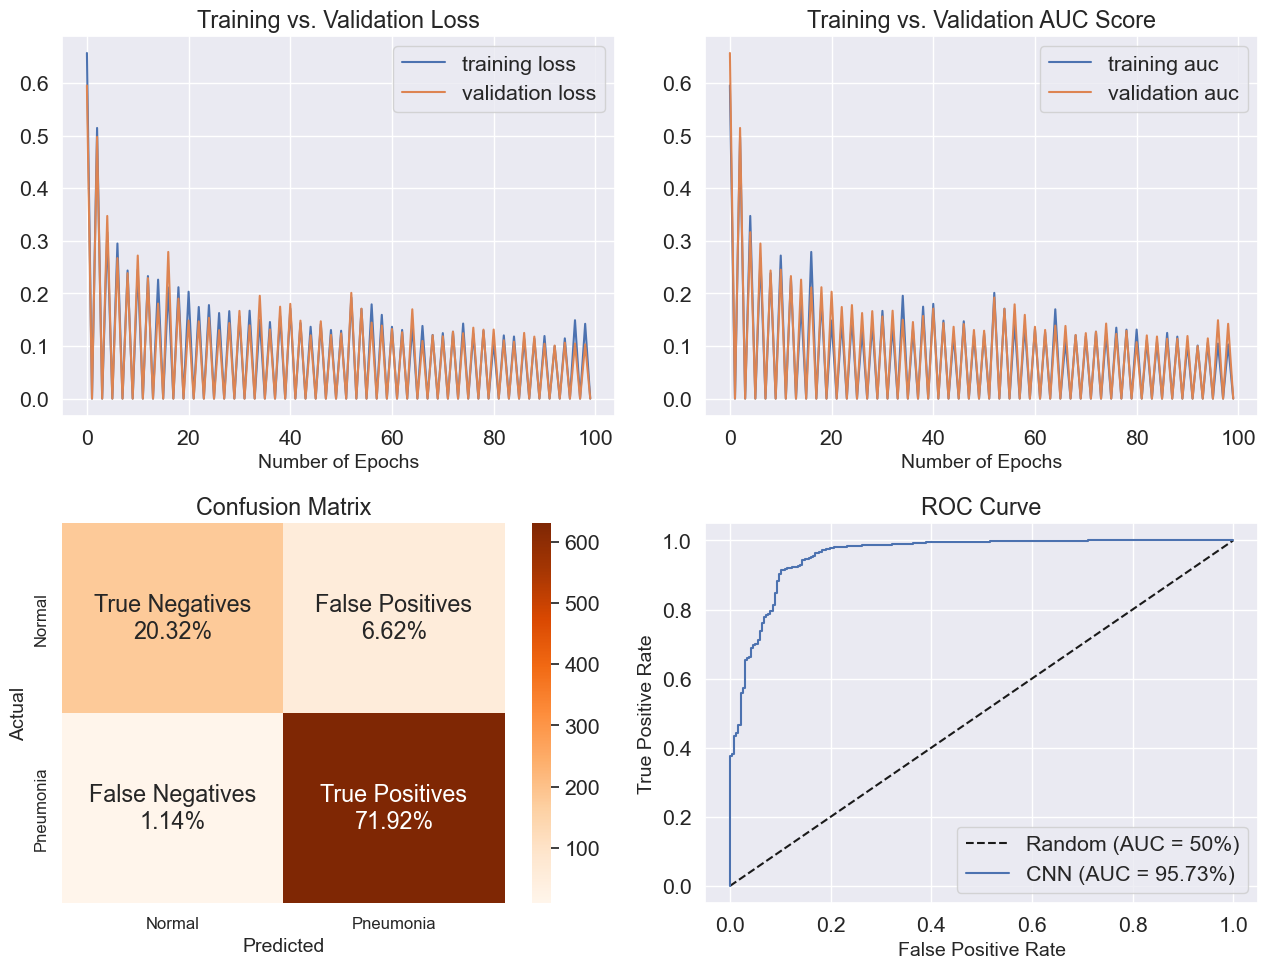

In [22]:
create_charts(cnn, cnn_model)